In [62]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [63]:
thermistor_num = [
    'thermistor_0/C',
    'thermistor_1/C',
    'thermistor_2/C',
    'thermistor_3/C',
    'thermistor_4/C',
    'thermistor_5/C',
    'thermistor_6/C',
    'thermistor_7/C'
]


In [64]:
# colors = ['tab:red', 'tab:green', 'tab:blue', 'lightskyblue', 
#           'tab:pink', 'tab:gray', 'black', 'tab:orange']

# plt.figure(figsize=(18, 14))

# # Plot each thermistor's data with a different color and label
# for i in range(8):
#     plt.plot(timestamp, thermistor_temperatures[:,i], label=thermistor_num[i], color=colors[i])

# plt.xlabel('Time (seconds)')
# plt.ylabel('Temperature (°C)')
# plt.title('Thermistor Temperature Over Time')
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

In [65]:
def sin_plus_line(t, A, omega, phi, B, C):
    return A * np.sin(omega * t + phi) + B * t + C

def initial_guess(t, y, omega_guess):
    A_guess = (np.max(y) - np.min(y)) / 2
    phi_guess = 0
    B_guess = 0  # Assuming no trend as initial guess
    C_guess = np.mean(y)
    return [A_guess, omega_guess, phi_guess, B_guess, C_guess]


In [66]:
def plot_fit():
    n_columns = thermistor_temperatures.shape[1]
    assert len(omega_guesses) == n_columns, "Length of omega_guesses must match number of columns"

    fit_results = []  
    for i in range(n_columns):
        y = thermistor_temperatures[:, i]
        omega_0 = omega_guesses[i]

        try:
            popt, pcov = curve_fit(
                sin_plus_line,
                timestamp,
                y,
                p0=initial_guess(timestamp, y, omega_0)
            )

            A, omega, phi, B, C = popt
            A, omega, phi, B, C = popt

            if A < 0:
                A = -A
                phi = phi + np.pi
                phi = (phi + np.pi) % (2 * np.pi) - np.pi  

            perr = np.sqrt(np.diag(pcov))
            A_err, omega_err, phi_err, B_err, C_err = perr

            period = 2 * np.pi / omega if omega != 0 else np.nan
            period_err = (2 * np.pi / omega**2) * omega_err if omega != 0 else np.nan

            fit_results.append({
                'column': i,
                'A': (A, A_err),
                'omega': (omega, omega_err),
                'phi': (phi, phi_err),
                'B': (B, B_err),
                'C': (C, C_err),
                'period': (period, period_err)
            })

            print(f"\nColumn {i} fit results:")
            print(f"  A     = {A:.4f} ± {A_err:.4f}")
            print(f"  omega = {omega:.6f} ± {omega_err:.6f} rad/s")
            print(f"  phi   = {phi:.4f} ± {phi_err:.4f} rad")
            print(f"  B     = {B:.6f} ± {B_err:.6f} (slope)")
            print(f"  C     = {C:.4f} ± {C_err:.4f} (offset)")
            print(f"  Period = {period:.4f} ± {period_err:.4f} s")

            t_fit = np.linspace(min(timestamp), max(timestamp), 1000)
            y_fit = sin_plus_line(t_fit, *popt)

            plt.figure(figsize=(8, 4))
            plt.plot(timestamp, y, 'o', label=f'Data (Column {i})', markersize=4)
            plt.plot(t_fit, y_fit, '-', label='Fit', linewidth=2)
            plt.xlabel('Time (s)')
            plt.ylabel('Temperature')
            plt.title(f'Fit for Column {i}')
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

        except RuntimeError as e:
            print(f"Fit failed for column {i}: {e}")
            fit_results.append({
                'column': i,
                'error': str(e)
            })

    for res in fit_results:
        if 'error' in res:
            print(f"\nColumn {res['column']}: Fit failed ({res['error']})")
        else:
            print(f"\nColumn {res['column']} fit results:")
            print(f"  A     = {res['A'][0]:.4f} ± {res['A'][1]:.4f}")
            print(f"  omega = {res['omega'][0]:.6f} ± {res['omega'][1]:.6f} rad/s")
            print(f"  phi   = {res['phi'][0]:.4f} ± {res['phi'][1]:.4f} rad")
            print(f"  B     = {res['B'][0]:.6f} ± {res['B'][1]:.6f} (slope)")
            print(f"  C     = {res['C'][0]:.4f} ± {res['C'][1]:.4f} (offset)")
            print(f"  Period = {res['period'][0]:.4f} ± {res['period'][1]:.4f} s")


In [67]:
def error_percentages (i):
        y = thermistor_temperatures[:, i]
        omega_0 = omega_guesses[i]

        popt, pcov = curve_fit(
            sin_plus_line,
            timestamp,
            y,
            p0=initial_guess(timestamp, y, omega_0)
        )

        A, omega, phi, B, C = popt
        perr = np.sqrt(np.diag(pcov))
        A_err, omega_err, phi_err, B_err, C_err = perr
        return (perr/popt)

In [68]:
def sin_fit_val(i):
    
    y = thermistor_temperatures[:, i]
    omega_0 = omega_guesses[i]

    popt, pcov = curve_fit(
        sin_plus_line,
        timestamp,
        y,
        p0=initial_guess(timestamp, y, omega_0)
    )

    A, omega, phi, B, C = popt

    if A < 0:
        A = -A
        phi = phi + np.pi

        phi = (phi + np.pi) % (2 * np.pi) - np.pi

    return np.array([A, omega, phi, B, C])

In [69]:
def error_from_two (a, b, quantity):
    a_errors_percentages = error_percentages(a)
    b_errors_percentages = error_percentages(b)
    result = np.sqrt((a_errors_percentages[quantity])**2 + (b_errors_percentages[quantity])**2)
    return result

In [70]:
def DA_DPhi(a, b):
    
    A_a, omega_a, phi_a, _, _ = sin_fit_val(a)
    A_b, omega_b, phi_b, _, _ = sin_fit_val(b)

    omega = np.mean([omega_a, omega_b])
    delta_d = 0.005 * np.abs(a - b)

    A_ratio = np.abs(A_b) / np.abs(A_a)
    delta_phi = np.abs(phi_b - phi_a)

    DA = omega * (delta_d)**2 / (2 * (np.log(A_ratio))**2)
    Dphi = omega * (delta_d)**2 / (2 * (delta_phi)**2)

    error_in_A_ratio = error_from_two(a, b, 0)      
    error_in_delta_phi = error_from_two(a, b, 2)    

    r_A = error_in_A_ratio / 100
    r_phi = error_in_delta_phi / 100

    DA_rel_error = 2 * r_A / np.abs(np.log(A_ratio))
    Dphi_rel_error = 2 * r_phi / np.abs(delta_phi)

    DA_error = DA * DA_rel_error
    Dphi_error = Dphi * Dphi_rel_error

    DA_error_percent = DA_rel_error * 100
    Dphi_error_percent = Dphi_rel_error * 100

    return {
        "DA": DA,
        "DA_error": DA_error,
        "DA_error_%": DA_error_percent,
        "Dphi": Dphi,
        "Dphi_error": Dphi_error,
        "Dphi_error_%": Dphi_error_percent
    }


In [71]:
def plot_D():
    i_values = []
    DA_values = []
    DA_err_values = []
    Dphi_values = []
    Dphi_err_values = []

    for i in range(7):
        result = DA_DPhi(0, i + 1)
        print(f"D from {i + 1}: {result}")
        
        i_values.append(i + 1)
        DA_values.append(result["DA"])
        DA_err_values.append(result["DA_error"])
        Dphi_values.append(result["Dphi"])
        Dphi_err_values.append(result["Dphi_error"])

    plt.figure(figsize=(8, 5))

    plt.errorbar(i_values, DA_values, yerr=DA_err_values, fmt='o-', capsize=5, label='DA ± DA_error')
    plt.errorbar(i_values, Dphi_values, yerr=Dphi_err_values, fmt='s--', capsize=5, label='Dphi ± Dphi_error')

    plt.title("DA & Dphi vs i (with error bars)")
    plt.xlabel("i")
    plt.ylabel("Value")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.show()


In [72]:
# for i in range (7):
#     print(f"D from {i+1} : {DA_DPhi(0, i+1)}")


Column 0 fit results:
  A     = 4.0930 ± 0.0020
  omega = 0.078641 ± 0.000001 rad/s
  phi   = -1.1399 ± 0.0013 rad
  B     = -0.000022 ± 0.000003 (slope)
  C     = 30.7790 ± 0.0036 (offset)
  Period = 79.8968 ± 0.0011 s


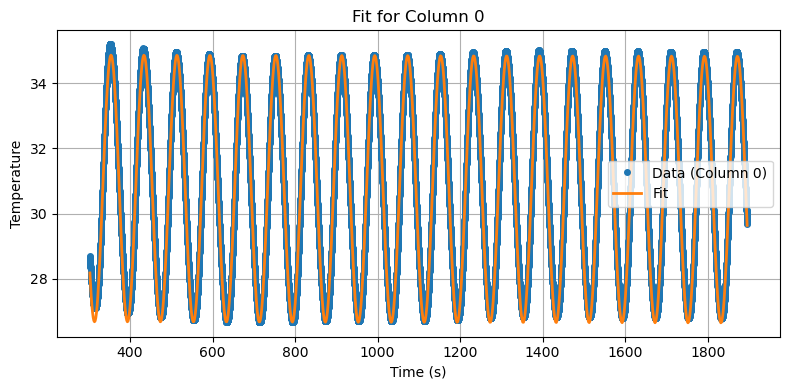


Column 1 fit results:
  A     = 3.4738 ± 0.0017
  omega = 0.078642 ± 0.000001 rad/s
  phi   = -1.3464 ± 0.0012 rad
  B     = -0.000026 ± 0.000003 (slope)
  C     = 30.7122 ± 0.0030 (offset)
  Period = 79.8962 ± 0.0011 s


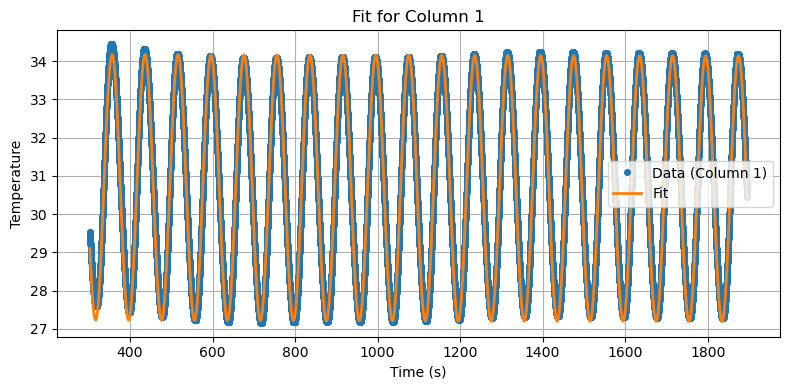


Column 2 fit results:
  A     = 2.9586 ± 0.0014
  omega = 0.078643 ± 0.000001 rad/s
  phi   = -1.5992 ± 0.0012 rad
  B     = -0.000030 ± 0.000002 (slope)
  C     = 30.7055 ± 0.0026 (offset)
  Period = 79.8951 ± 0.0011 s


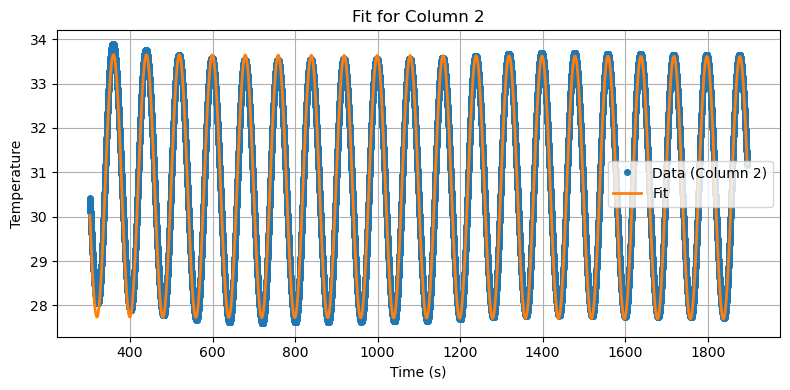


Column 3 fit results:
  A     = 2.6393 ± 0.0013
  omega = 0.078644 ± 0.000001 rad/s
  phi   = -1.8226 ± 0.0012 rad
  B     = -0.000032 ± 0.000002 (slope)
  C     = 30.6715 ± 0.0023 (offset)
  Period = 79.8937 ± 0.0011 s


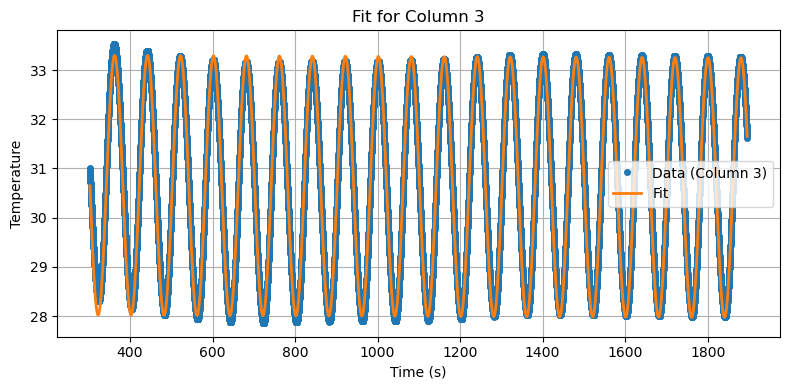


Column 4 fit results:
  A     = 2.4545 ± 0.0012
  omega = 0.078646 ± 0.000001 rad/s
  phi   = -2.0392 ± 0.0013 rad
  B     = -0.000034 ± 0.000002 (slope)
  C     = 30.7258 ± 0.0022 (offset)
  Period = 79.8920 ± 0.0011 s


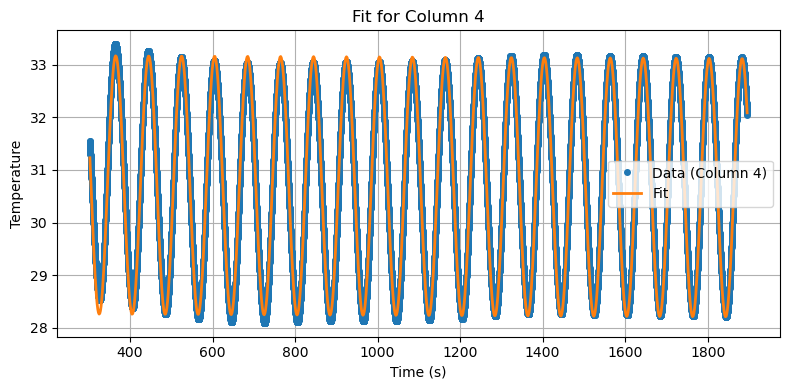


Column 5 fit results:
  A     = 2.3673 ± 0.0012
  omega = 0.078647 ± 0.000001 rad/s
  phi   = -2.2247 ± 0.0013 rad
  B     = -0.000036 ± 0.000002 (slope)
  C     = 30.6310 ± 0.0021 (offset)
  Period = 79.8905 ± 0.0011 s


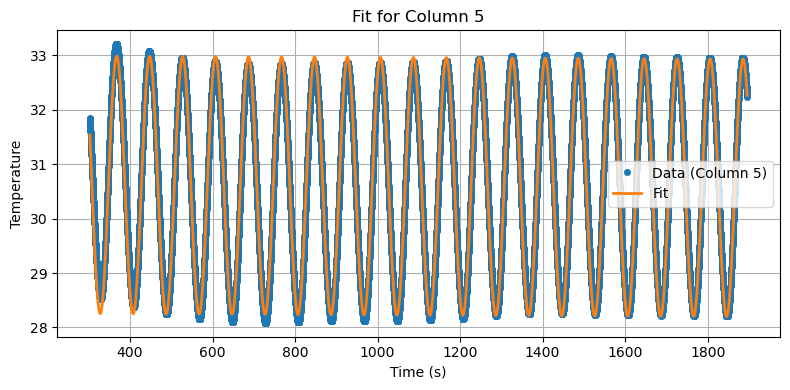


Column 6 fit results:
  A     = 2.3372 ± 0.0012
  omega = 0.078648 ± 0.000001 rad/s
  phi   = -2.3520 ± 0.0013 rad
  B     = -0.000037 ± 0.000002 (slope)
  C     = 30.5993 ± 0.0021 (offset)
  Period = 79.8896 ± 0.0011 s


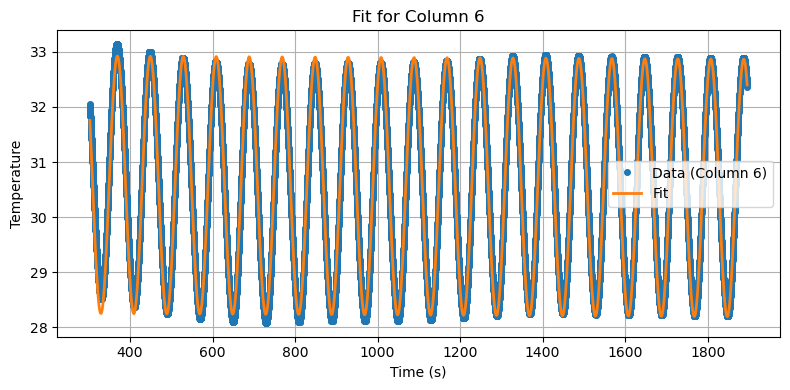


Column 7 fit results:
  A     = 2.3305 ± 0.0012
  omega = 0.078649 ± 0.000001 rad/s
  phi   = -2.4132 ± 0.0013 rad
  B     = -0.000037 ± 0.000002 (slope)
  C     = 30.5927 ± 0.0021 (offset)
  Period = 79.8891 ± 0.0011 s


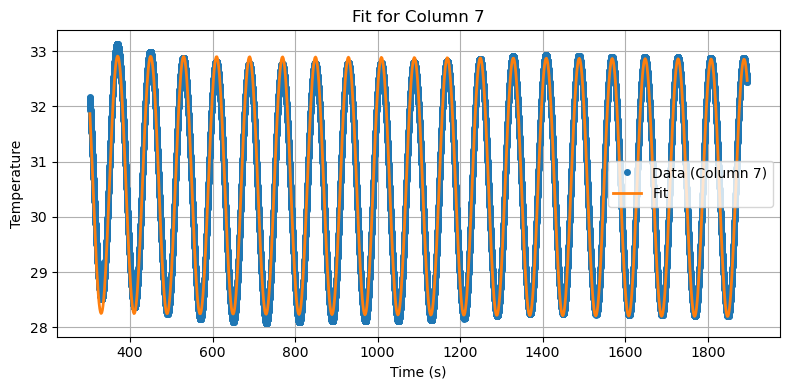


Column 0 fit results:
  A     = 4.0930 ± 0.0020
  omega = 0.078641 ± 0.000001 rad/s
  phi   = -1.1399 ± 0.0013 rad
  B     = -0.000022 ± 0.000003 (slope)
  C     = 30.7790 ± 0.0036 (offset)
  Period = 79.8968 ± 0.0011 s

Column 1 fit results:
  A     = 3.4738 ± 0.0017
  omega = 0.078642 ± 0.000001 rad/s
  phi   = -1.3464 ± 0.0012 rad
  B     = -0.000026 ± 0.000003 (slope)
  C     = 30.7122 ± 0.0030 (offset)
  Period = 79.8962 ± 0.0011 s

Column 2 fit results:
  A     = 2.9586 ± 0.0014
  omega = 0.078643 ± 0.000001 rad/s
  phi   = -1.5992 ± 0.0012 rad
  B     = -0.000030 ± 0.000002 (slope)
  C     = 30.7055 ± 0.0026 (offset)
  Period = 79.8951 ± 0.0011 s

Column 3 fit results:
  A     = 2.6393 ± 0.0013
  omega = 0.078644 ± 0.000001 rad/s
  phi   = -1.8226 ± 0.0012 rad
  B     = -0.000032 ± 0.000002 (slope)
  C     = 30.6715 ± 0.0023 (offset)
  Period = 79.8937 ± 0.0011 s

Column 4 fit results:
  A     = 2.4545 ± 0.0012
  omega = 0.078646 ± 0.000001 rad/s
  phi   = -2.0392 ± 0.0013 rad


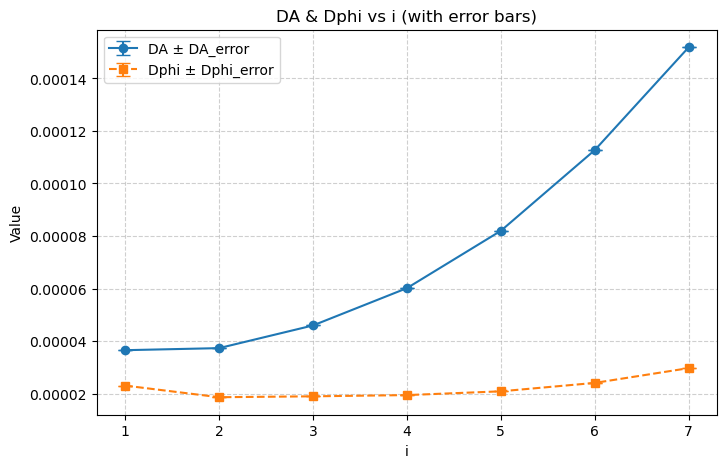

In [73]:
omega_guesses = [2 * np.pi / 80] * 8

def load_dataset(path):
	
	data = pd.read_csv(path, header=3)
	timestamp = data.iloc[:, 0].to_numpy()
	output_voltage = data.iloc[:, 1].to_numpy()
	output_current = data.iloc[:, 2].to_numpy()
	thermistor_temperatures = data.iloc[:, 3:].to_numpy()

	comments = re.search(r"Comments: (.*)$", open(path).read(), re.MULTILINE)[1]

	return timestamp, output_voltage, output_current, thermistor_temperatures, comments

timestamp, output_voltage, output_current, thermistor_temperatures, comments = (
	load_dataset("../data/brass data/brass 80s.csv")
)

plot_fit()

plot_D()



Column 0 fit results:
  A     = 2.7358 ± 0.0017
  omega = 0.125702 ± 0.000003 rad/s
  phi   = -1.0210 ± 0.0023 rad
  B     = -0.000383 ± 0.000006 (slope)
  C     = 28.9836 ± 0.0045 (offset)
  Period = 49.9849 ± 0.0012 s


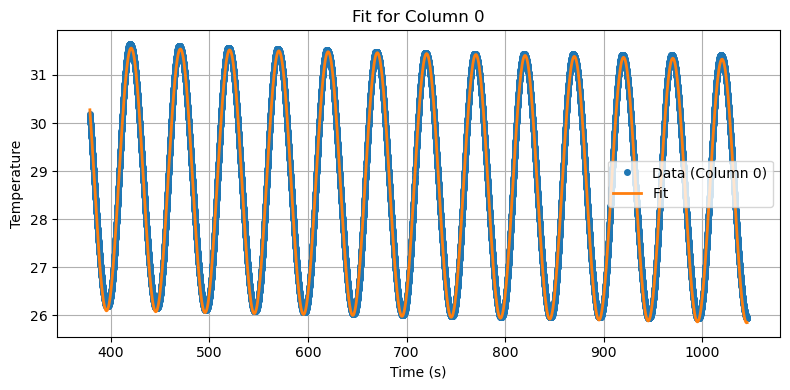


Column 1 fit results:
  A     = 2.1837 ± 0.0013
  omega = 0.125700 ± 0.000003 rad/s
  phi   = -1.2495 ± 0.0022 rad
  B     = -0.000392 ± 0.000005 (slope)
  C     = 28.9128 ± 0.0034 (offset)
  Period = 49.9854 ± 0.0012 s


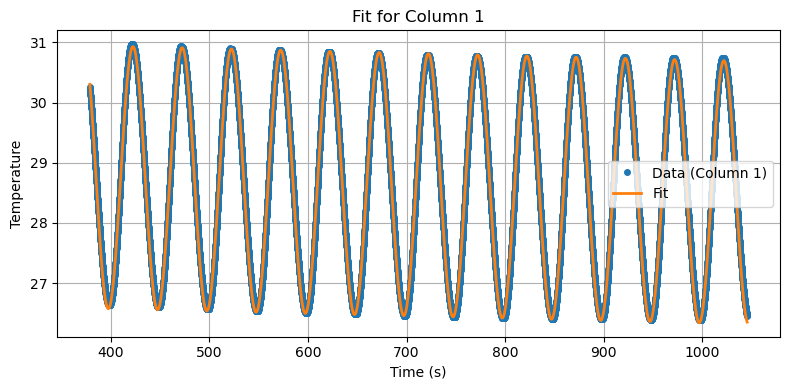


Column 2 fit results:
  A     = 1.7116 ± 0.0009
  omega = 0.125700 ± 0.000003 rad/s
  phi   = -1.5386 ± 0.0020 rad
  B     = -0.000399 ± 0.000003 (slope)
  C     = 28.9097 ± 0.0025 (offset)
  Period = 49.9854 ± 0.0011 s


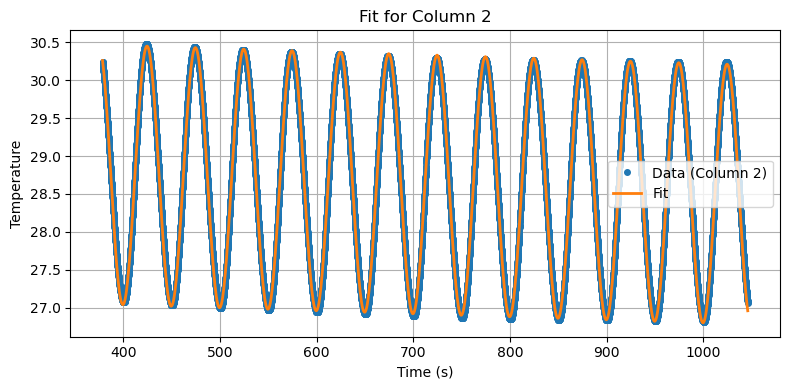


Column 3 fit results:
  A     = 1.3997 ± 0.0007
  omega = 0.125702 ± 0.000003 rad/s
  phi   = -1.8079 ± 0.0019 rad
  B     = -0.000405 ± 0.000003 (slope)
  C     = 28.8767 ± 0.0019 (offset)
  Period = 49.9848 ± 0.0010 s


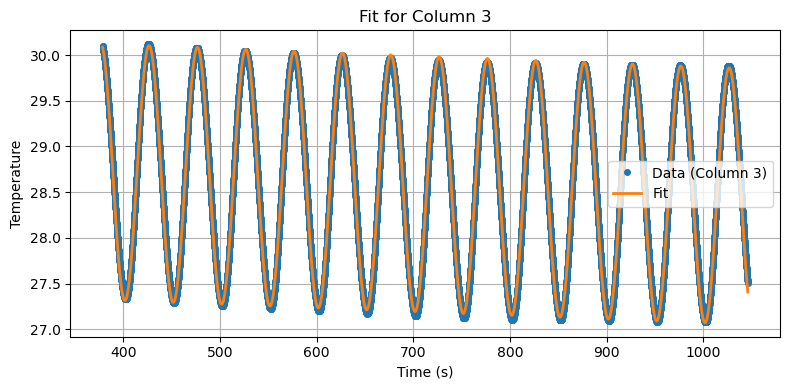


Column 4 fit results:
  A     = 1.2071 ± 0.0006
  omega = 0.125705 ± 0.000002 rad/s
  phi   = -2.1048 ± 0.0018 rad
  B     = -0.000409 ± 0.000002 (slope)
  C     = 28.9361 ± 0.0015 (offset)
  Period = 49.9838 ± 0.0010 s


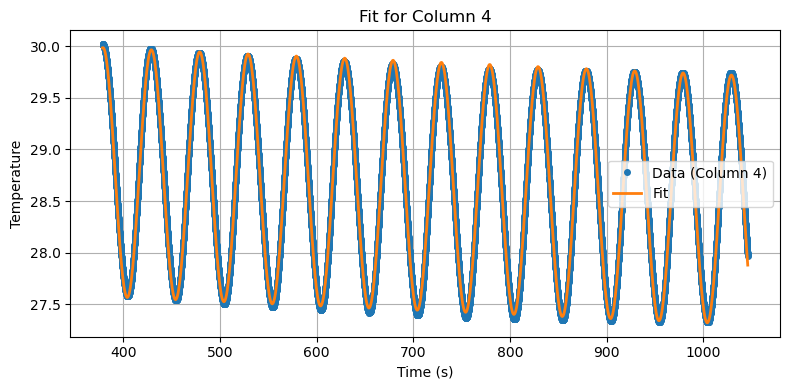


Column 5 fit results:
  A     = 1.1105 ± 0.0005
  omega = 0.125707 ± 0.000002 rad/s
  phi   = -2.3810 ± 0.0016 rad
  B     = -0.000414 ± 0.000002 (slope)
  C     = 28.8415 ± 0.0013 (offset)
  Period = 49.9828 ± 0.0009 s


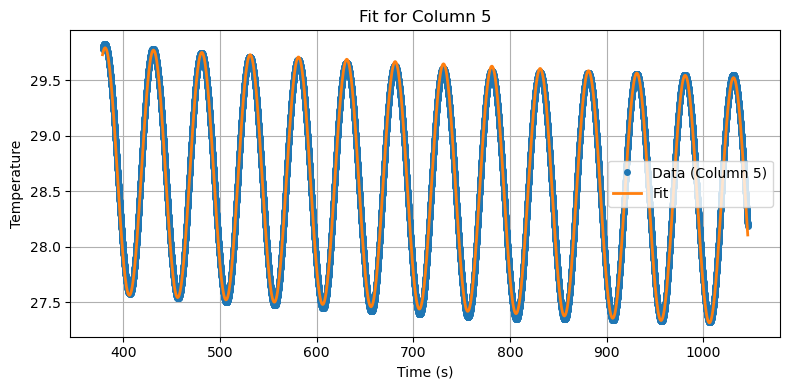


Column 6 fit results:
  A     = 1.0773 ± 0.0004
  omega = 0.125709 ± 0.000002 rad/s
  phi   = -2.5800 ± 0.0016 rad
  B     = -0.000417 ± 0.000002 (slope)
  C     = 28.8110 ± 0.0012 (offset)
  Period = 49.9822 ± 0.0009 s


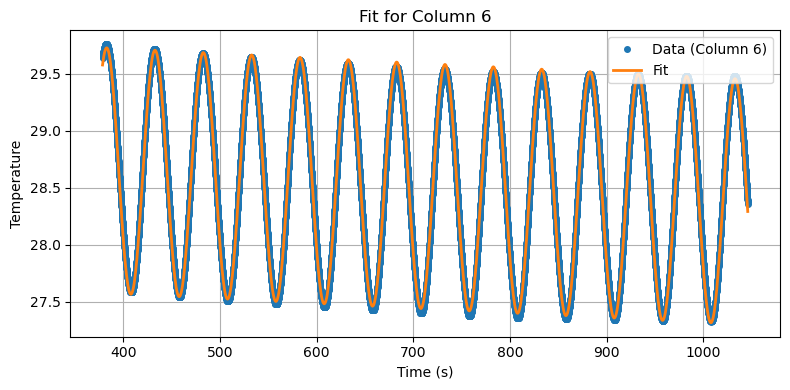


Column 7 fit results:
  A     = 1.0713 ± 0.0005
  omega = 0.125709 ± 0.000002 rad/s
  phi   = -2.6773 ± 0.0016 rad
  B     = -0.000418 ± 0.000002 (slope)
  C     = 28.8058 ± 0.0012 (offset)
  Period = 49.9820 ± 0.0009 s


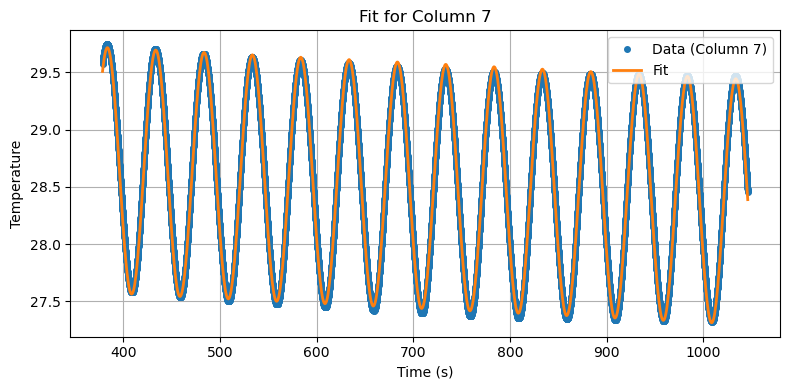


Column 0 fit results:
  A     = 2.7358 ± 0.0017
  omega = 0.125702 ± 0.000003 rad/s
  phi   = -1.0210 ± 0.0023 rad
  B     = -0.000383 ± 0.000006 (slope)
  C     = 28.9836 ± 0.0045 (offset)
  Period = 49.9849 ± 0.0012 s

Column 1 fit results:
  A     = 2.1837 ± 0.0013
  omega = 0.125700 ± 0.000003 rad/s
  phi   = -1.2495 ± 0.0022 rad
  B     = -0.000392 ± 0.000005 (slope)
  C     = 28.9128 ± 0.0034 (offset)
  Period = 49.9854 ± 0.0012 s

Column 2 fit results:
  A     = 1.7116 ± 0.0009
  omega = 0.125700 ± 0.000003 rad/s
  phi   = -1.5386 ± 0.0020 rad
  B     = -0.000399 ± 0.000003 (slope)
  C     = 28.9097 ± 0.0025 (offset)
  Period = 49.9854 ± 0.0011 s

Column 3 fit results:
  A     = 1.3997 ± 0.0007
  omega = 0.125702 ± 0.000003 rad/s
  phi   = -1.8079 ± 0.0019 rad
  B     = -0.000405 ± 0.000003 (slope)
  C     = 28.8767 ± 0.0019 (offset)
  Period = 49.9848 ± 0.0010 s

Column 4 fit results:
  A     = 1.2071 ± 0.0006
  omega = 0.125705 ± 0.000002 rad/s
  phi   = -2.1048 ± 0.0018 rad


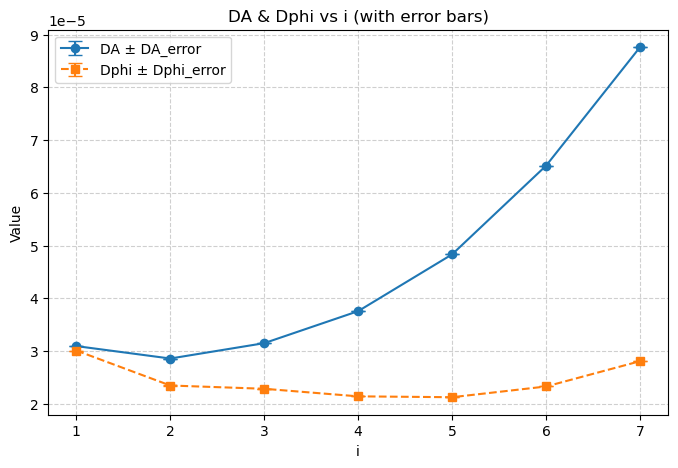

In [75]:
omega_guesses = [2 * np.pi / 50] * 8

def load_dataset(path):
	
	data = pd.read_csv(path, header=3)
	timestamp = data.iloc[:, 0].to_numpy()
	output_voltage = data.iloc[:, 1].to_numpy()
	output_current = data.iloc[:, 2].to_numpy()
	thermistor_temperatures = data.iloc[:, 3:].to_numpy()

	comments = re.search(r"Comments: (.*)$", open(path).read(), re.MULTILINE)[1]

	return timestamp, output_voltage, output_current, thermistor_temperatures, comments

timestamp, output_voltage, output_current, thermistor_temperatures, comments = (
	load_dataset("../data/brass data/new brass 50s.csv")
)

plot_fit()

plot_D()



Column 0 fit results:
  A     = 2.4858 ± 0.0014
  omega = 0.139656 ± 0.000002 rad/s
  phi   = -0.5555 ± 0.0020 rad
  B     = 0.000053 ± 0.000004 (slope)
  C     = 28.8333 ± 0.0035 (offset)
  Period = 44.9904 ± 0.0008 s


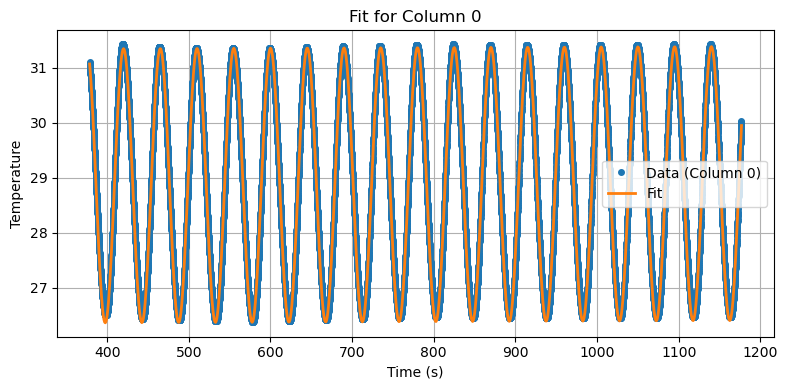


Column 1 fit results:
  A     = 1.9608 ± 0.0011
  omega = 0.139659 ± 0.000002 rad/s
  phi   = -0.7928 ± 0.0019 rad
  B     = 0.000045 ± 0.000003 (slope)
  C     = 28.7614 ± 0.0027 (offset)
  Period = 44.9896 ± 0.0008 s


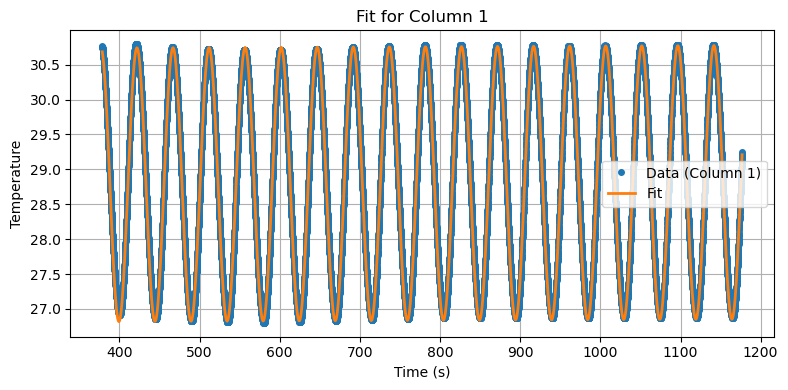


Column 2 fit results:
  A     = 1.5101 ± 0.0008
  omega = 0.139662 ± 0.000002 rad/s
  phi   = -1.0925 ± 0.0019 rad
  B     = 0.000038 ± 0.000003 (slope)
  C     = 28.7573 ± 0.0020 (offset)
  Period = 44.9885 ± 0.0008 s


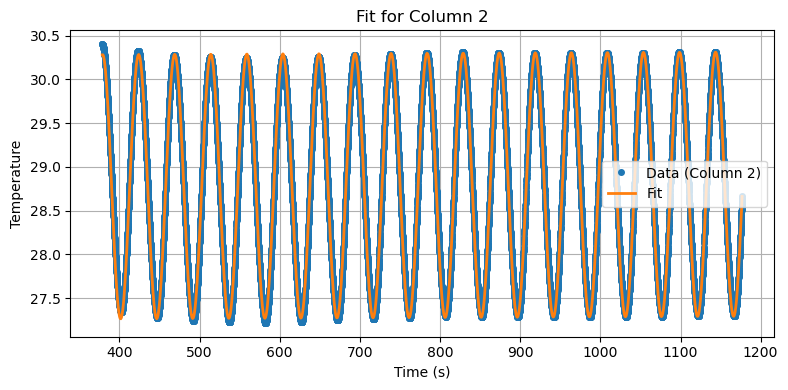


Column 3 fit results:
  A     = 1.2093 ± 0.0007
  omega = 0.139665 ± 0.000002 rad/s
  phi   = -1.3700 ± 0.0019 rad
  B     = 0.000033 ± 0.000002 (slope)
  C     = 28.7235 ± 0.0016 (offset)
  Period = 44.9875 ± 0.0008 s


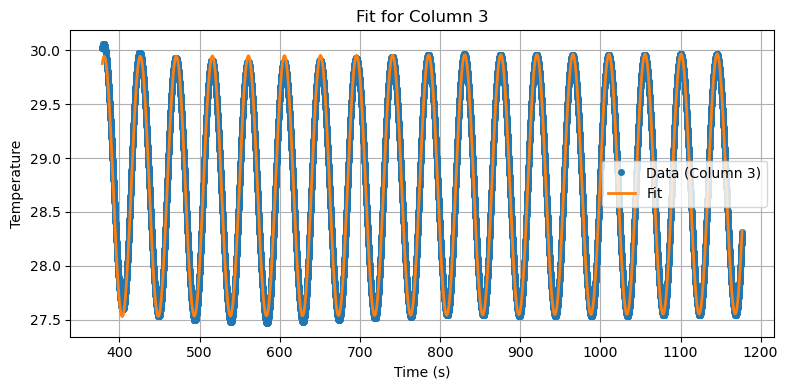


Column 4 fit results:
  A     = 1.0203 ± 0.0006
  omega = 0.139665 ± 0.000003 rad/s
  phi   = -1.6820 ± 0.0020 rad
  B     = 0.000028 ± 0.000002 (slope)
  C     = 28.7824 ± 0.0014 (offset)
  Period = 44.9874 ± 0.0008 s


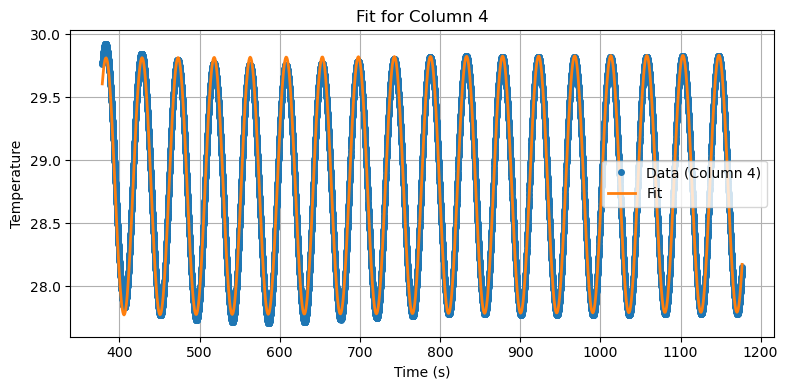


Column 5 fit results:
  A     = 0.9234 ± 0.0005
  omega = 0.139662 ± 0.000003 rad/s
  phi   = -1.9770 ± 0.0021 rad
  B     = 0.000024 ± 0.000002 (slope)
  C     = 28.6871 ± 0.0013 (offset)
  Period = 44.9885 ± 0.0008 s


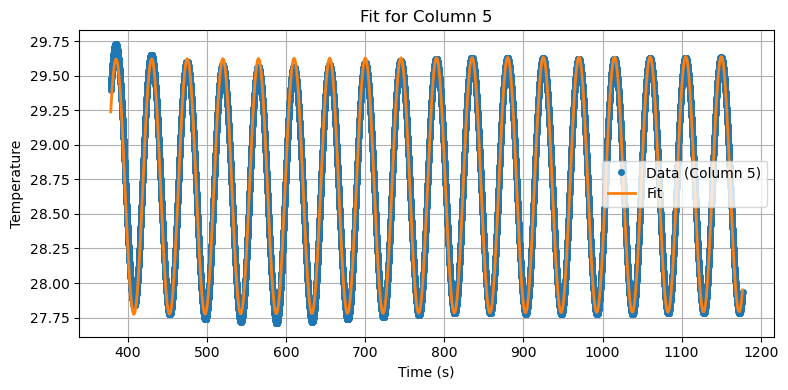


Column 6 fit results:
  A     = 0.8900 ± 0.0005
  omega = 0.139657 ± 0.000003 rad/s
  phi   = -2.1918 ± 0.0021 rad
  B     = 0.000021 ± 0.000002 (slope)
  C     = 28.6562 ± 0.0013 (offset)
  Period = 44.9900 ± 0.0009 s


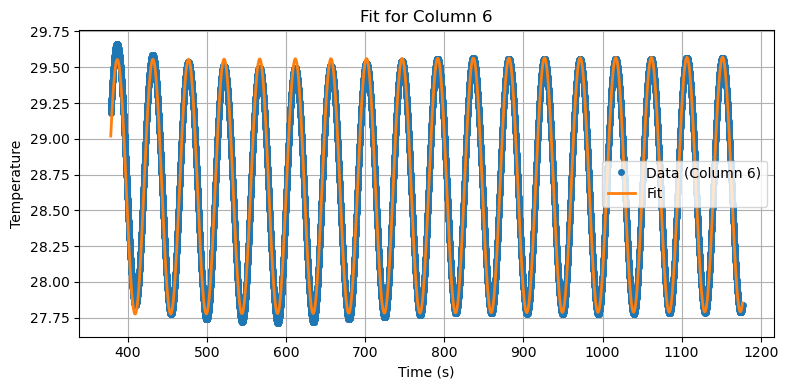


Column 7 fit results:
  A     = 0.8841 ± 0.0005
  omega = 0.139655 ± 0.000003 rad/s
  phi   = -2.2973 ± 0.0022 rad
  B     = 0.000020 ± 0.000002 (slope)
  C     = 28.6512 ± 0.0013 (offset)
  Period = 44.9909 ± 0.0009 s


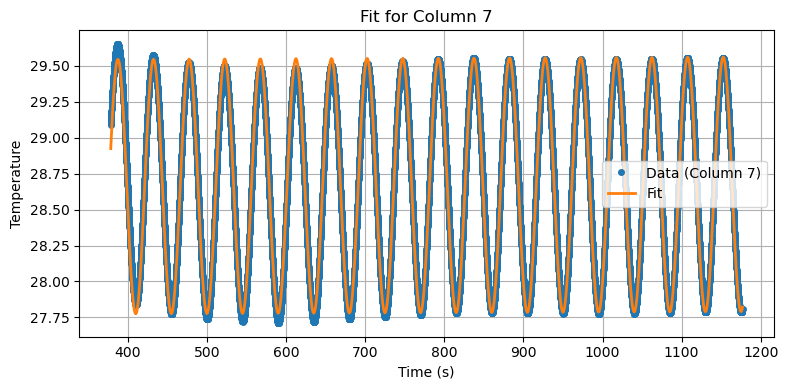


Column 0 fit results:
  A     = 2.4858 ± 0.0014
  omega = 0.139656 ± 0.000002 rad/s
  phi   = -0.5555 ± 0.0020 rad
  B     = 0.000053 ± 0.000004 (slope)
  C     = 28.8333 ± 0.0035 (offset)
  Period = 44.9904 ± 0.0008 s

Column 1 fit results:
  A     = 1.9608 ± 0.0011
  omega = 0.139659 ± 0.000002 rad/s
  phi   = -0.7928 ± 0.0019 rad
  B     = 0.000045 ± 0.000003 (slope)
  C     = 28.7614 ± 0.0027 (offset)
  Period = 44.9896 ± 0.0008 s

Column 2 fit results:
  A     = 1.5101 ± 0.0008
  omega = 0.139662 ± 0.000002 rad/s
  phi   = -1.0925 ± 0.0019 rad
  B     = 0.000038 ± 0.000003 (slope)
  C     = 28.7573 ± 0.0020 (offset)
  Period = 44.9885 ± 0.0008 s

Column 3 fit results:
  A     = 1.2093 ± 0.0007
  omega = 0.139665 ± 0.000002 rad/s
  phi   = -1.3700 ± 0.0019 rad
  B     = 0.000033 ± 0.000002 (slope)
  C     = 28.7235 ± 0.0016 (offset)
  Period = 44.9875 ± 0.0008 s

Column 4 fit results:
  A     = 1.0203 ± 0.0006
  omega = 0.139665 ± 0.000003 rad/s
  phi   = -1.6820 ± 0.0020 rad
  B 

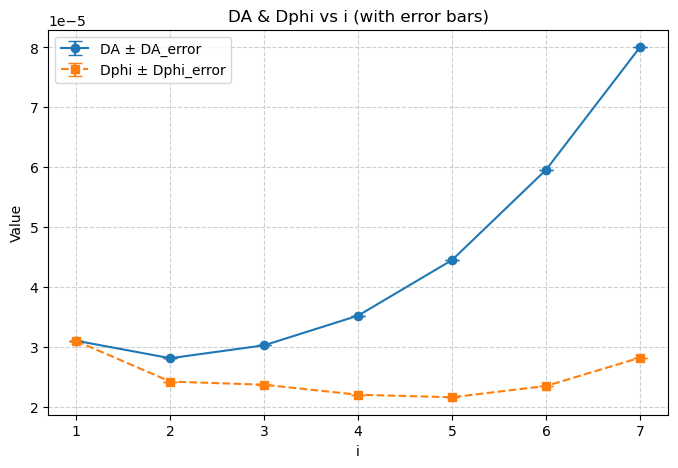

In [76]:
omega_guesses = [2 * np.pi / 45] * 8

def load_dataset(path):
	
	data = pd.read_csv(path, header=3)
	timestamp = data.iloc[:, 0].to_numpy()
	output_voltage = data.iloc[:, 1].to_numpy()
	output_current = data.iloc[:, 2].to_numpy()
	thermistor_temperatures = data.iloc[:, 3:].to_numpy()

	comments = re.search(r"Comments: (.*)$", open(path).read(), re.MULTILINE)[1]

	return timestamp, output_voltage, output_current, thermistor_temperatures, comments

timestamp, output_voltage, output_current, thermistor_temperatures, comments = (
	load_dataset("../data/brass data/new brass 45s.csv")
)

plot_fit()

plot_D()



Column 0 fit results:
  A     = 2.2283 ± 0.0013
  omega = 0.157315 ± 0.000003 rad/s
  phi   = -0.9423 ± 0.0017 rad
  B     = 0.000828 ± 0.000004 (slope)
  C     = 30.3440 ± 0.0026 (offset)
  Period = 39.9402 ± 0.0007 s


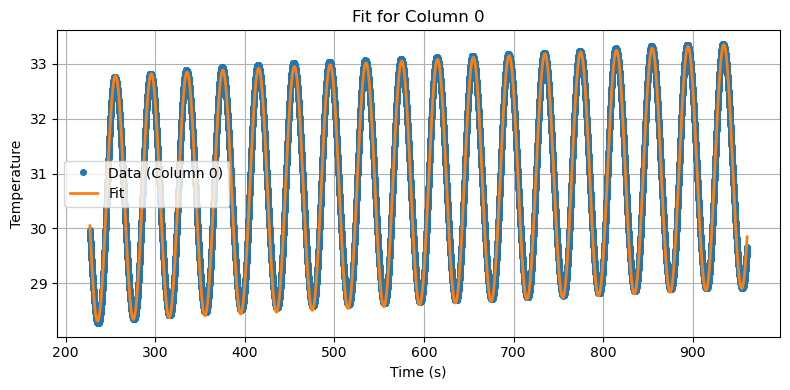


Column 1 fit results:
  A     = 1.7390 ± 0.0009
  omega = 0.157315 ± 0.000003 rad/s
  phi   = -1.1826 ± 0.0016 rad
  B     = 0.000840 ± 0.000003 (slope)
  C     = 30.2598 ± 0.0020 (offset)
  Period = 39.9402 ± 0.0007 s


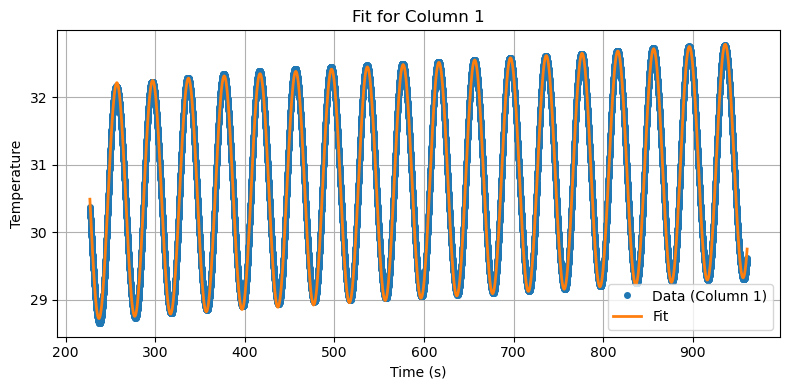


Column 2 fit results:
  A     = 1.3128 ± 0.0007
  omega = 0.157312 ± 0.000003 rad/s
  phi   = -1.4872 ± 0.0016 rad
  B     = 0.000848 ± 0.000002 (slope)
  C     = 30.2381 ± 0.0015 (offset)
  Period = 39.9410 ± 0.0006 s


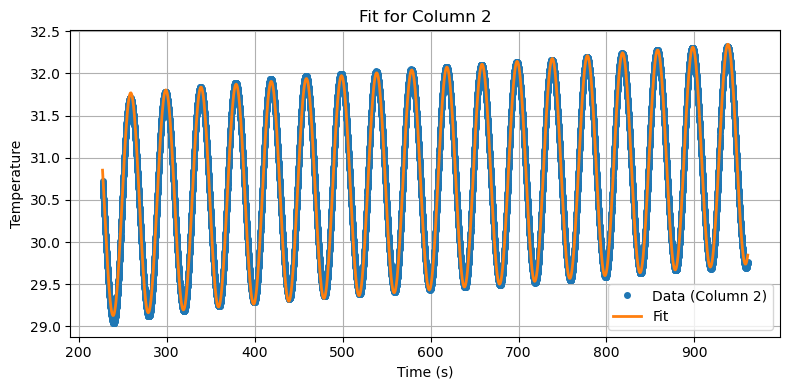


Column 3 fit results:
  A     = 1.0267 ± 0.0006
  omega = 0.157307 ± 0.000003 rad/s
  phi   = 4.5180 ± 0.0016 rad
  B     = 0.000855 ± 0.000002 (slope)
  C     = 30.1934 ± 0.0012 (offset)
  Period = 39.9421 ± 0.0006 s


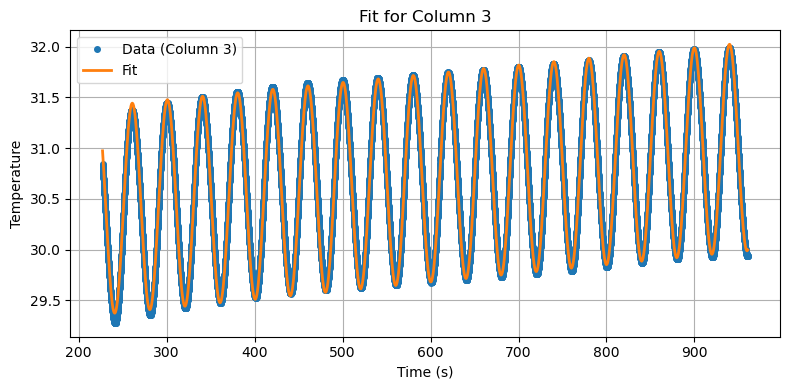


Column 4 fit results:
  A     = 0.8427 ± 0.0005
  omega = 0.157302 ± 0.000003 rad/s
  phi   = -2.0897 ± 0.0017 rad
  B     = 0.000858 ± 0.000002 (slope)
  C     = 30.2394 ± 0.0010 (offset)
  Period = 39.9434 ± 0.0007 s


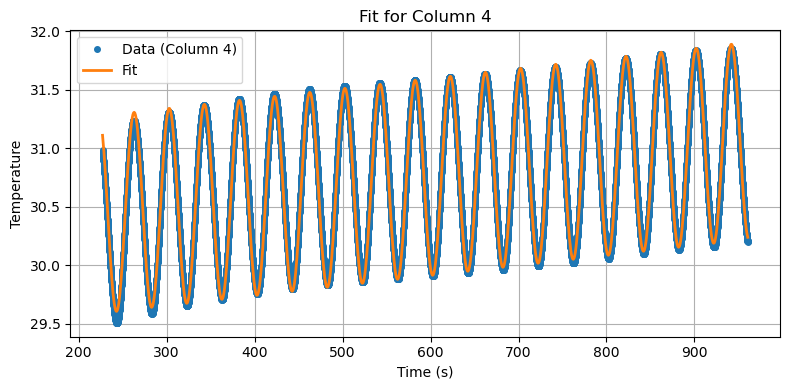


Column 5 fit results:
  A     = 0.7454 ± 0.0005
  omega = 0.157297 ± 0.000003 rad/s
  phi   = -2.4114 ± 0.0018 rad
  B     = 0.000861 ± 0.000002 (slope)
  C     = 30.1378 ± 0.0010 (offset)
  Period = 39.9447 ± 0.0007 s


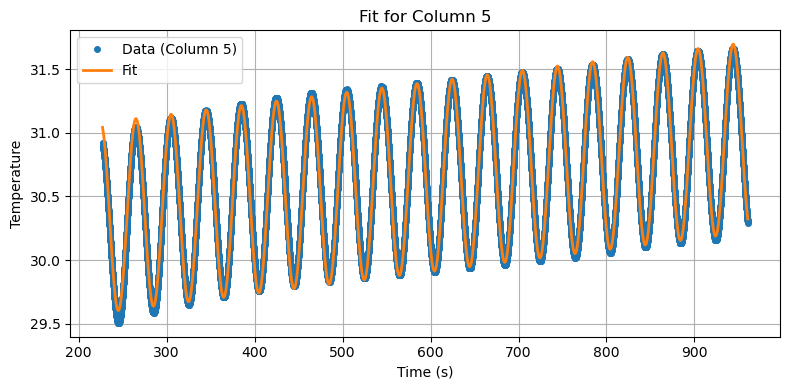


Column 6 fit results:
  A     = 0.7110 ± 0.0004
  omega = 0.157295 ± 0.000003 rad/s
  phi   = -2.6538 ± 0.0019 rad
  B     = 0.000864 ± 0.000001 (slope)
  C     = 30.1017 ± 0.0009 (offset)
  Period = 39.9452 ± 0.0007 s


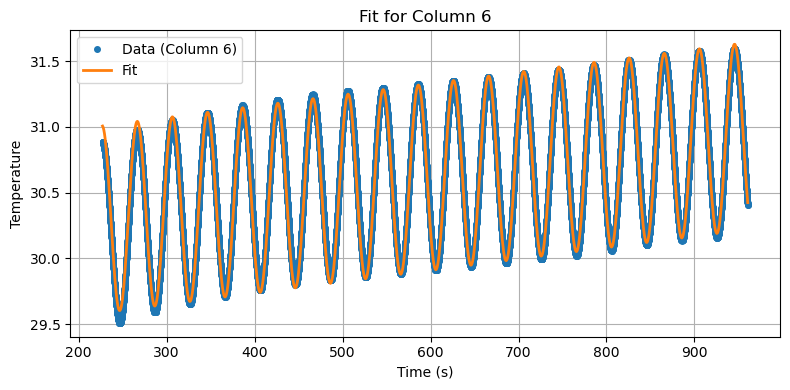


Column 7 fit results:
  A     = 0.7049 ± 0.0004
  omega = 0.157295 ± 0.000003 rad/s
  phi   = -2.7750 ± 0.0019 rad
  B     = 0.000864 ± 0.000001 (slope)
  C     = 30.0939 ± 0.0009 (offset)
  Period = 39.9453 ± 0.0008 s


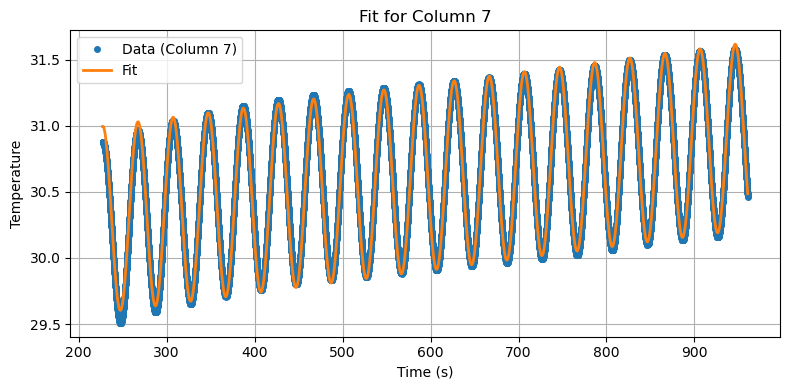


Column 0 fit results:
  A     = 2.2283 ± 0.0013
  omega = 0.157315 ± 0.000003 rad/s
  phi   = -0.9423 ± 0.0017 rad
  B     = 0.000828 ± 0.000004 (slope)
  C     = 30.3440 ± 0.0026 (offset)
  Period = 39.9402 ± 0.0007 s

Column 1 fit results:
  A     = 1.7390 ± 0.0009
  omega = 0.157315 ± 0.000003 rad/s
  phi   = -1.1826 ± 0.0016 rad
  B     = 0.000840 ± 0.000003 (slope)
  C     = 30.2598 ± 0.0020 (offset)
  Period = 39.9402 ± 0.0007 s

Column 2 fit results:
  A     = 1.3128 ± 0.0007
  omega = 0.157312 ± 0.000003 rad/s
  phi   = -1.4872 ± 0.0016 rad
  B     = 0.000848 ± 0.000002 (slope)
  C     = 30.2381 ± 0.0015 (offset)
  Period = 39.9410 ± 0.0006 s

Column 3 fit results:
  A     = 1.0267 ± 0.0006
  omega = 0.157307 ± 0.000003 rad/s
  phi   = 4.5180 ± 0.0016 rad
  B     = 0.000855 ± 0.000002 (slope)
  C     = 30.1934 ± 0.0012 (offset)
  Period = 39.9421 ± 0.0006 s

Column 4 fit results:
  A     = 0.8427 ± 0.0005
  omega = 0.157302 ± 0.000003 rad/s
  phi   = -2.0897 ± 0.0017 rad
  B  

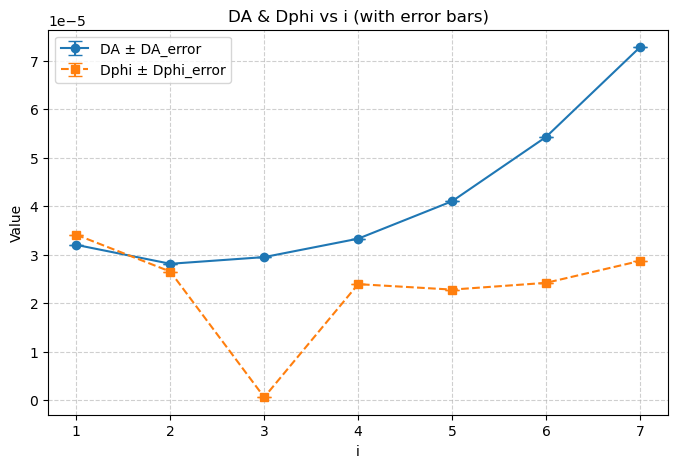

In [80]:
omega_guesses = [2 * np.pi / 40] * 8

def load_dataset(path):
	
	data = pd.read_csv(path, header=3)
	timestamp = data.iloc[:, 0].to_numpy()
	output_voltage = data.iloc[:, 1].to_numpy()
	output_current = data.iloc[:, 2].to_numpy()
	thermistor_temperatures = data.iloc[:, 3:].to_numpy()

	comments = re.search(r"Comments: (.*)$", open(path).read(), re.MULTILINE)[1]

	return timestamp, output_voltage, output_current, thermistor_temperatures, comments

timestamp, output_voltage, output_current, thermistor_temperatures, comments = (
	load_dataset("../data/brass data/brass 40s.csv")
)

plot_fit()

plot_D()



Column 0 fit results:
  A     = 1.6834 ± 0.0012
  omega = 0.209936 ± 0.000006 rad/s
  phi   = -1.7806 ± 0.0014 rad
  B     = 0.000132 ± 0.000007 (slope)
  C     = 31.8070 ± 0.0016 (offset)
  Period = 29.9291 ± 0.0008 s


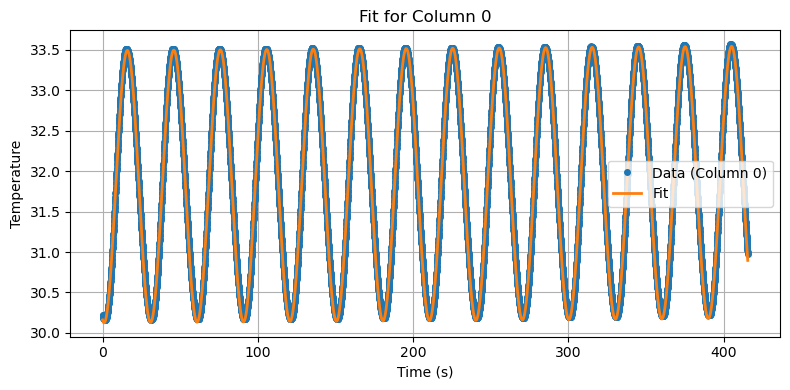


Column 1 fit results:
  A     = 1.2748 ± 0.0008
  omega = 0.209938 ± 0.000005 rad/s
  phi   = -2.0468 ± 0.0013 rad
  B     = 0.000126 ± 0.000005 (slope)
  C     = 31.7707 ± 0.0011 (offset)
  Period = 29.9288 ± 0.0007 s


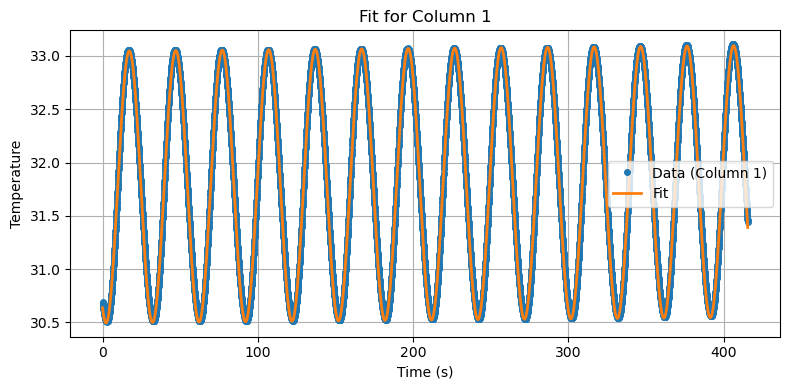


Column 2 fit results:
  A     = 0.9203 ± 0.0005
  omega = 0.209940 ± 0.000005 rad/s
  phi   = -2.3825 ± 0.0011 rad
  B     = 0.000122 ± 0.000003 (slope)
  C     = 31.7544 ± 0.0007 (offset)
  Period = 29.9285 ± 0.0007 s


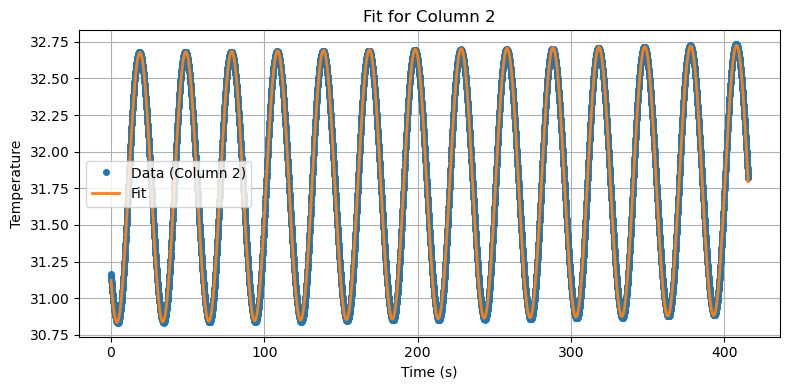


Column 3 fit results:
  A     = 0.6824 ± 0.0003
  omega = 0.209942 ± 0.000004 rad/s
  phi   = -2.6758 ± 0.0010 rad
  B     = 0.000120 ± 0.000002 (slope)
  C     = 31.7155 ± 0.0005 (offset)
  Period = 29.9282 ± 0.0006 s


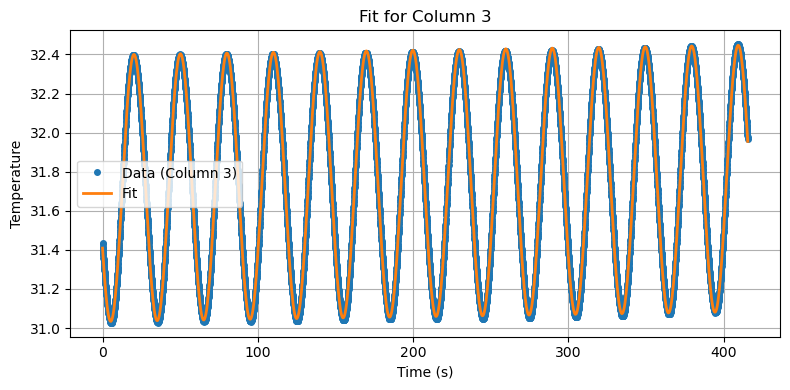


Column 4 fit results:
  A     = 0.5220 ± 0.0002
  omega = 0.209945 ± 0.000004 rad/s
  phi   = -3.0417 ± 0.0009 rad
  B     = 0.000119 ± 0.000001 (slope)
  C     = 31.7710 ± 0.0003 (offset)
  Period = 29.9278 ± 0.0006 s


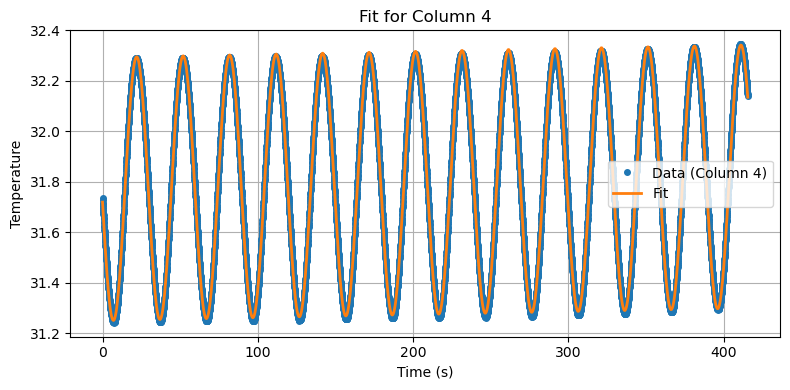


Column 5 fit results:
  A     = 0.4327 ± 0.0002
  omega = 0.209946 ± 0.000003 rad/s
  phi   = 2.8488 ± 0.0007 rad
  B     = 0.000119 ± 0.000001 (slope)
  C     = 31.7404 ± 0.0002 (offset)
  Period = 29.9276 ± 0.0004 s


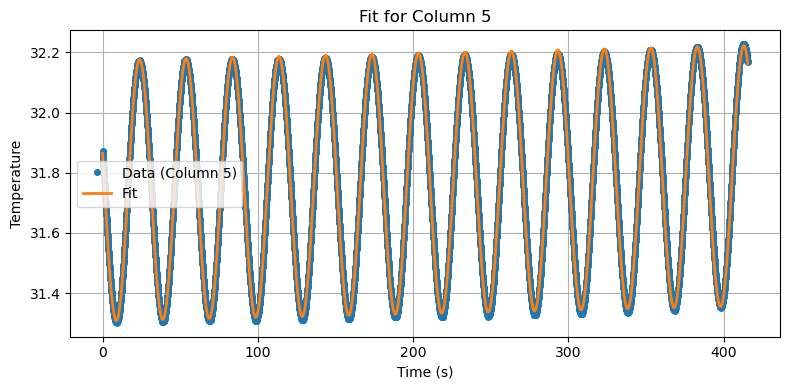


Column 6 fit results:
  A     = 0.4004 ± 0.0001
  omega = 0.209948 ± 0.000003 rad/s
  phi   = 2.5344 ± 0.0007 rad
  B     = 0.000119 ± 0.000001 (slope)
  C     = 31.7944 ± 0.0002 (offset)
  Period = 29.9274 ± 0.0004 s


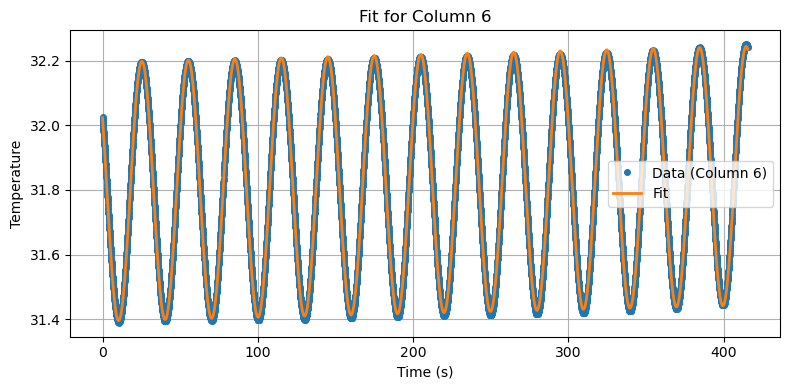


Column 7 fit results:
  A     = 0.3949 ± 0.0001
  omega = 0.209948 ± 0.000003 rad/s
  phi   = 2.3723 ± 0.0006 rad
  B     = 0.000118 ± 0.000001 (slope)
  C     = 31.7146 ± 0.0002 (offset)
  Period = 29.9274 ± 0.0004 s


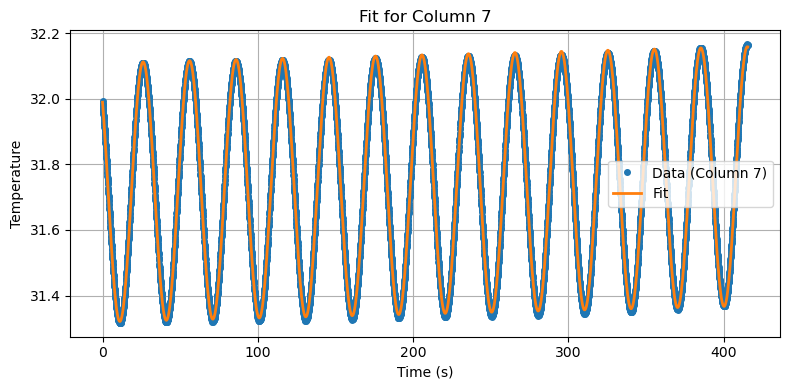


Column 0 fit results:
  A     = 1.6834 ± 0.0012
  omega = 0.209936 ± 0.000006 rad/s
  phi   = -1.7806 ± 0.0014 rad
  B     = 0.000132 ± 0.000007 (slope)
  C     = 31.8070 ± 0.0016 (offset)
  Period = 29.9291 ± 0.0008 s

Column 1 fit results:
  A     = 1.2748 ± 0.0008
  omega = 0.209938 ± 0.000005 rad/s
  phi   = -2.0468 ± 0.0013 rad
  B     = 0.000126 ± 0.000005 (slope)
  C     = 31.7707 ± 0.0011 (offset)
  Period = 29.9288 ± 0.0007 s

Column 2 fit results:
  A     = 0.9203 ± 0.0005
  omega = 0.209940 ± 0.000005 rad/s
  phi   = -2.3825 ± 0.0011 rad
  B     = 0.000122 ± 0.000003 (slope)
  C     = 31.7544 ± 0.0007 (offset)
  Period = 29.9285 ± 0.0007 s

Column 3 fit results:
  A     = 0.6824 ± 0.0003
  omega = 0.209942 ± 0.000004 rad/s
  phi   = -2.6758 ± 0.0010 rad
  B     = 0.000120 ± 0.000002 (slope)
  C     = 31.7155 ± 0.0005 (offset)
  Period = 29.9282 ± 0.0006 s

Column 4 fit results:
  A     = 0.5220 ± 0.0002
  omega = 0.209945 ± 0.000004 rad/s
  phi   = -3.0417 ± 0.0009 rad
  B 

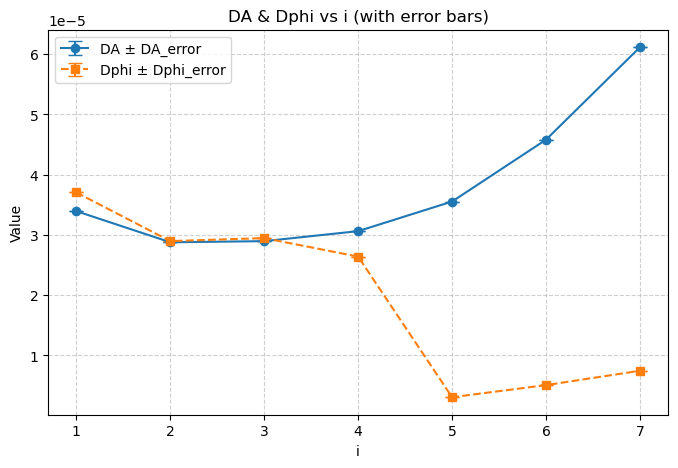

In [81]:
omega_guesses = [2 * np.pi / 30] * 8

def load_dataset(path):
	
	data = pd.read_csv(path, header=3)
	timestamp = data.iloc[:, 0].to_numpy()
	output_voltage = data.iloc[:, 1].to_numpy()
	output_current = data.iloc[:, 2].to_numpy()
	thermistor_temperatures = data.iloc[:, 3:].to_numpy()

	comments = re.search(r"Comments: (.*)$", open(path).read(), re.MULTILINE)[1]

	return timestamp, output_voltage, output_current, thermistor_temperatures, comments

timestamp, output_voltage, output_current, thermistor_temperatures, comments = (
	load_dataset("../data/brass data/brass 30s.csv")
)

plot_fit()

plot_D()



Column 0 fit results:
  A     = 1.1105 ± 0.0008
  omega = 0.314768 ± 0.000008 rad/s
  phi   = -1.7006 ± 0.0015 rad
  B     = 0.000349 ± 0.000006 (slope)
  C     = 31.6703 ± 0.0012 (offset)
  Period = 19.9613 ± 0.0005 s


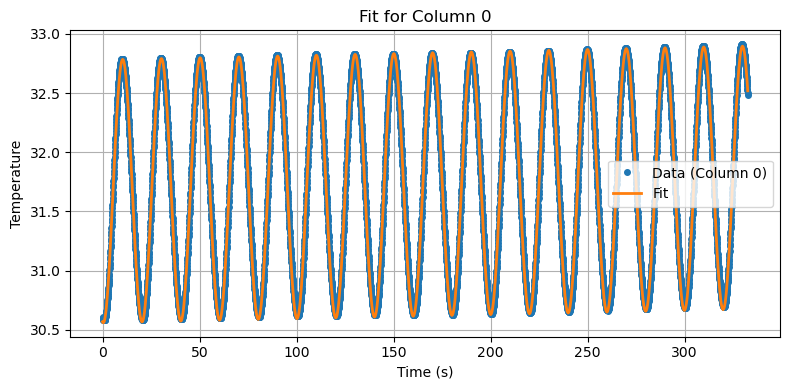


Column 1 fit results:
  A     = 0.7996 ± 0.0005
  omega = 0.314769 ± 0.000007 rad/s
  phi   = -2.0236 ± 0.0013 rad
  B     = 0.000346 ± 0.000004 (slope)
  C     = 31.6321 ± 0.0007 (offset)
  Period = 19.9613 ± 0.0004 s


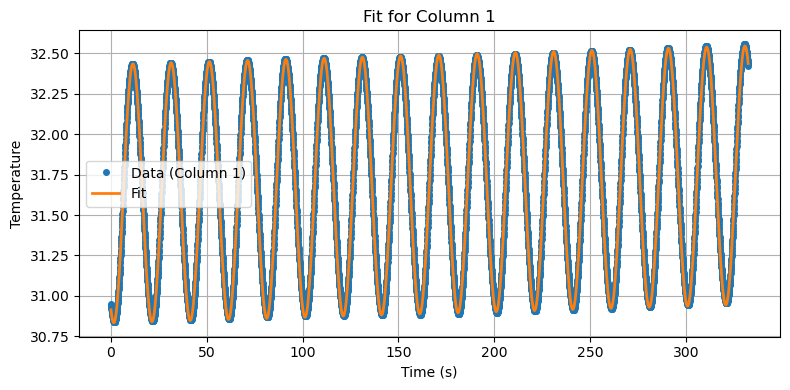


Column 2 fit results:
  A     = 0.5427 ± 0.0003
  omega = 0.314773 ± 0.000006 rad/s
  phi   = -2.4202 ± 0.0012 rad
  B     = 0.000340 ± 0.000002 (slope)
  C     = 31.6146 ± 0.0005 (offset)
  Period = 19.9610 ± 0.0004 s


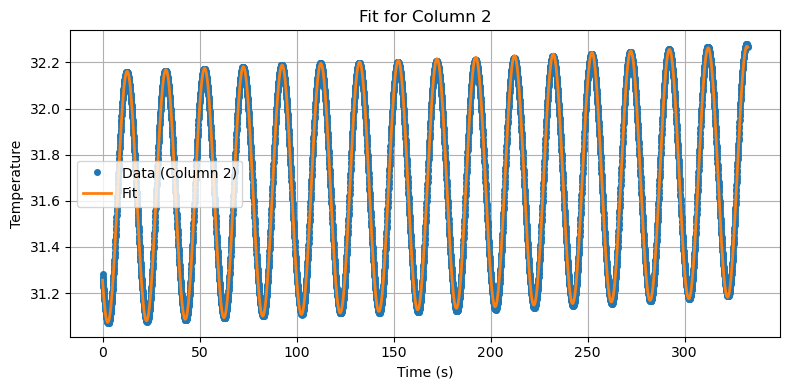


Column 3 fit results:
  A     = 0.3777 ± 0.0002
  omega = 0.314778 ± 0.000006 rad/s
  phi   = -2.7340 ± 0.0011 rad
  B     = 0.000337 ± 0.000002 (slope)
  C     = 31.5749 ± 0.0003 (offset)
  Period = 19.9607 ± 0.0004 s


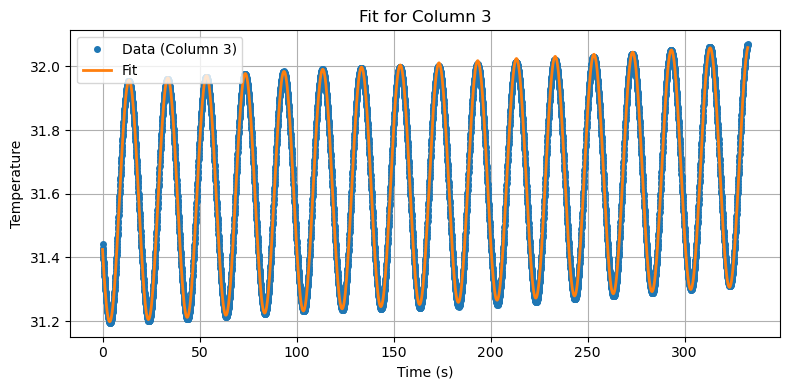


Column 4 fit results:
  A     = 0.2614 ± 0.0002
  omega = 0.314784 ± 0.000006 rad/s
  phi   = -3.1408 ± 0.0012 rad
  B     = 0.000335 ± 0.000001 (slope)
  C     = 31.6294 ± 0.0002 (offset)
  Period = 19.9603 ± 0.0004 s


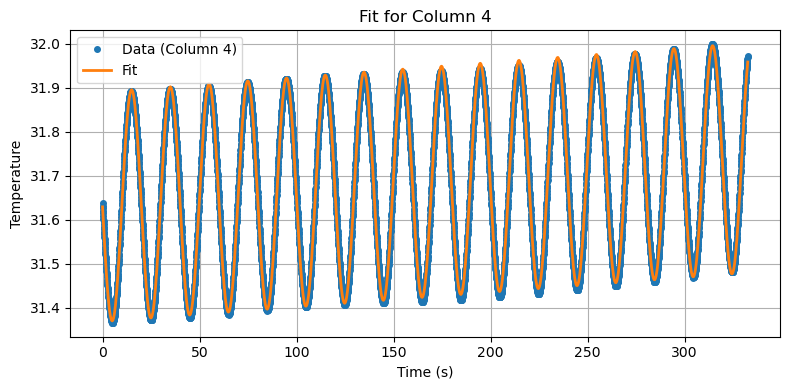


Column 5 fit results:
  A     = 0.1913 ± 0.0001
  omega = 0.314782 ± 0.000006 rad/s
  phi   = 2.6676 ± 0.0012 rad
  B     = 0.000332 ± 0.000001 (slope)
  C     = 31.5987 ± 0.0002 (offset)
  Period = 19.9604 ± 0.0004 s


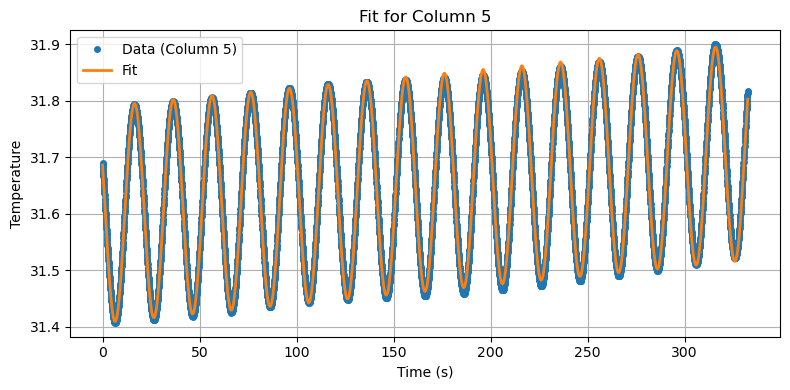


Column 6 fit results:
  A     = 0.1638 ± 0.0001
  omega = 0.314774 ± 0.000006 rad/s
  phi   = 2.2336 ± 0.0012 rad
  B     = 0.000331 ± 0.000001 (slope)
  C     = 31.6521 ± 0.0001 (offset)
  Period = 19.9610 ± 0.0004 s


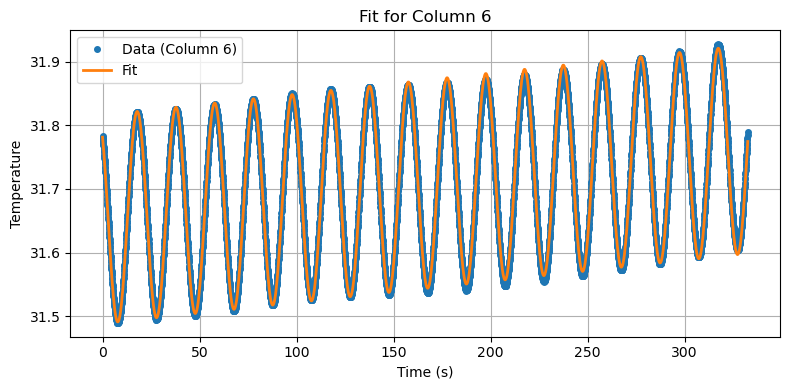


Column 7 fit results:
  A     = 0.1592 ± 0.0001
  omega = 0.314768 ± 0.000006 rad/s
  phi   = 1.9917 ± 0.0012 rad
  B     = 0.000330 ± 0.000001 (slope)
  C     = 31.5720 ± 0.0001 (offset)
  Period = 19.9613 ± 0.0004 s


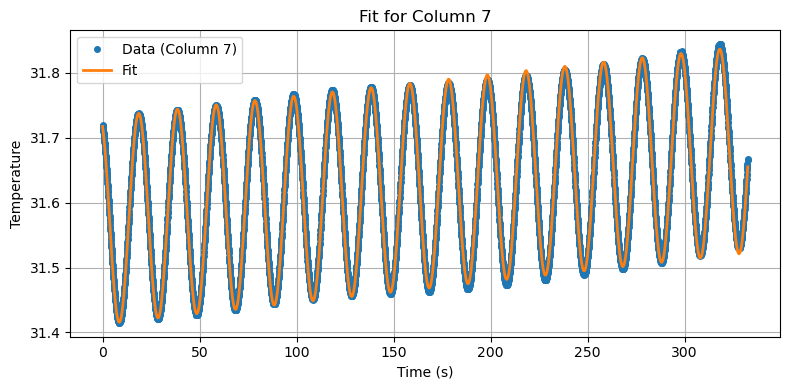


Column 0 fit results:
  A     = 1.1105 ± 0.0008
  omega = 0.314768 ± 0.000008 rad/s
  phi   = -1.7006 ± 0.0015 rad
  B     = 0.000349 ± 0.000006 (slope)
  C     = 31.6703 ± 0.0012 (offset)
  Period = 19.9613 ± 0.0005 s

Column 1 fit results:
  A     = 0.7996 ± 0.0005
  omega = 0.314769 ± 0.000007 rad/s
  phi   = -2.0236 ± 0.0013 rad
  B     = 0.000346 ± 0.000004 (slope)
  C     = 31.6321 ± 0.0007 (offset)
  Period = 19.9613 ± 0.0004 s

Column 2 fit results:
  A     = 0.5427 ± 0.0003
  omega = 0.314773 ± 0.000006 rad/s
  phi   = -2.4202 ± 0.0012 rad
  B     = 0.000340 ± 0.000002 (slope)
  C     = 31.6146 ± 0.0005 (offset)
  Period = 19.9610 ± 0.0004 s

Column 3 fit results:
  A     = 0.3777 ± 0.0002
  omega = 0.314778 ± 0.000006 rad/s
  phi   = -2.7340 ± 0.0011 rad
  B     = 0.000337 ± 0.000002 (slope)
  C     = 31.5749 ± 0.0003 (offset)
  Period = 19.9607 ± 0.0004 s

Column 4 fit results:
  A     = 0.2614 ± 0.0002
  omega = 0.314784 ± 0.000006 rad/s
  phi   = -3.1408 ± 0.0012 rad
  B 

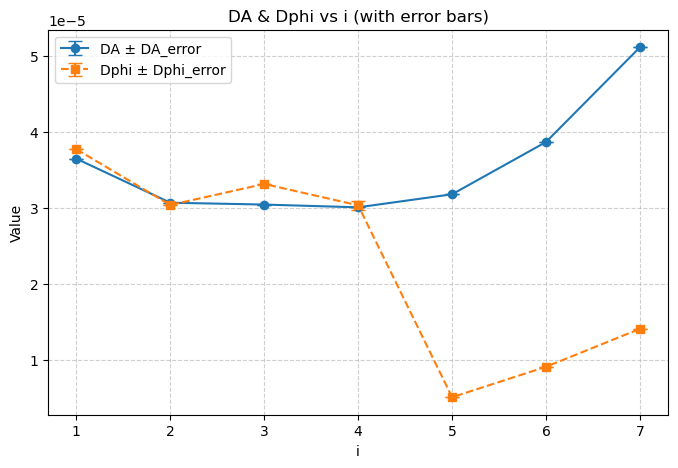

In [82]:
omega_guesses = [2 * np.pi / 20] * 8

def load_dataset(path):
	
	data = pd.read_csv(path, header=3)
	timestamp = data.iloc[:, 0].to_numpy()
	output_voltage = data.iloc[:, 1].to_numpy()
	output_current = data.iloc[:, 2].to_numpy()
	thermistor_temperatures = data.iloc[:, 3:].to_numpy()

	comments = re.search(r"Comments: (.*)$", open(path).read(), re.MULTILINE)[1]

	return timestamp, output_voltage, output_current, thermistor_temperatures, comments

timestamp, output_voltage, output_current, thermistor_temperatures, comments = (
	load_dataset("../data/brass data/brass 20s.csv")
)

plot_fit()

plot_D()



Column 0 fit results:
  A     = 0.8176 ± 0.0007
  omega = 0.419842 ± 0.000015 rad/s
  phi   = 2.7358 ± 0.0018 rad
  B     = 0.000117 ± 0.000009 (slope)
  C     = 32.6007 ± 0.0010 (offset)
  Period = 14.9656 ± 0.0005 s


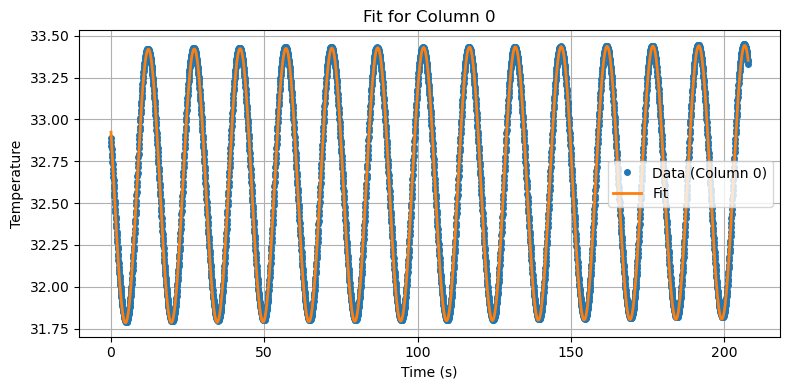


Column 1 fit results:
  A     = 0.5649 ± 0.0004
  omega = 0.419836 ± 0.000013 rad/s
  phi   = 2.3653 ± 0.0015 rad
  B     = 0.000119 ± 0.000005 (slope)
  C     = 32.5659 ± 0.0006 (offset)
  Period = 14.9658 ± 0.0005 s


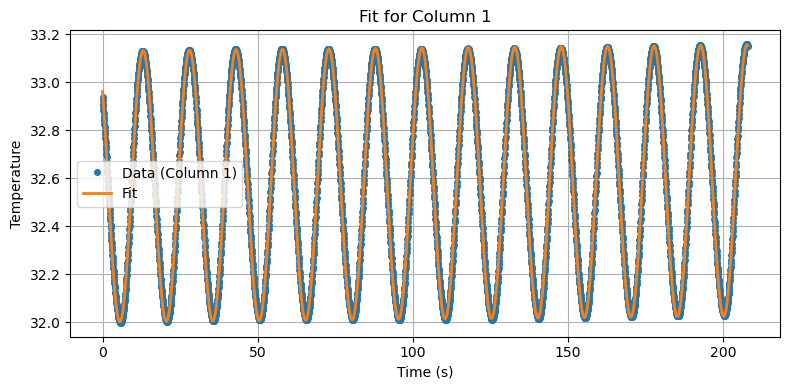


Column 2 fit results:
  A     = 0.3626 ± 0.0002
  omega = 0.419834 ± 0.000011 rad/s
  phi   = 1.9035 ± 0.0013 rad
  B     = 0.000118 ± 0.000003 (slope)
  C     = 32.5485 ± 0.0003 (offset)
  Period = 14.9659 ± 0.0004 s


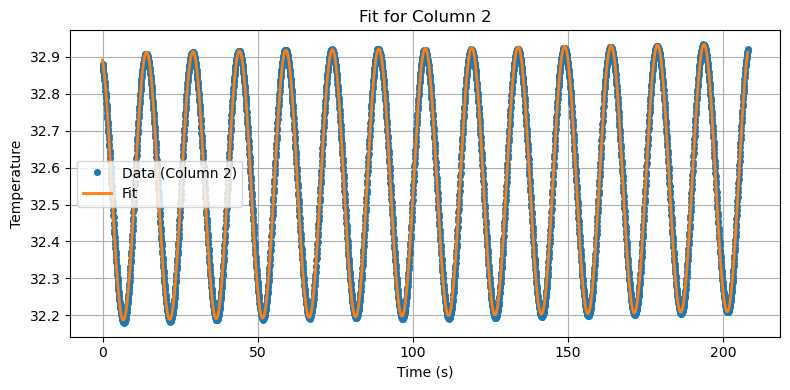


Column 3 fit results:
  A     = 0.2425 ± 0.0001
  omega = 0.419834 ± 0.000010 rad/s
  phi   = 1.5622 ± 0.0012 rad
  B     = 0.000117 ± 0.000002 (slope)
  C     = 32.5092 ± 0.0002 (offset)
  Period = 14.9659 ± 0.0004 s


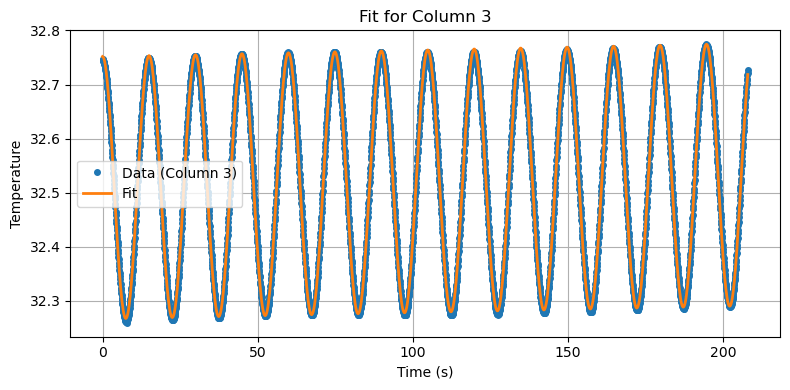


Column 4 fit results:
  A     = 0.1574 ± 0.0001
  omega = 0.419834 ± 0.000010 rad/s
  phi   = 1.1257 ± 0.0012 rad
  B     = 0.000116 ± 0.000001 (slope)
  C     = 32.5635 ± 0.0001 (offset)
  Period = 14.9659 ± 0.0003 s


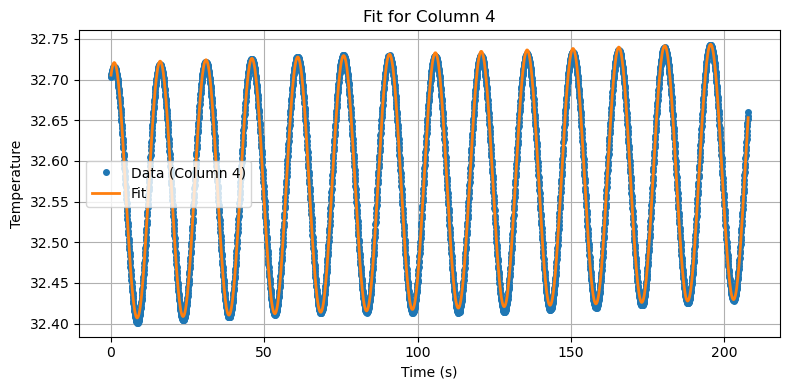


Column 5 fit results:
  A     = 0.1044 ± 0.0001
  omega = 0.419817 ± 0.000011 rad/s
  phi   = 0.6064 ± 0.0013 rad
  B     = 0.000114 ± 0.000001 (slope)
  C     = 32.5337 ± 0.0001 (offset)
  Period = 14.9665 ± 0.0004 s


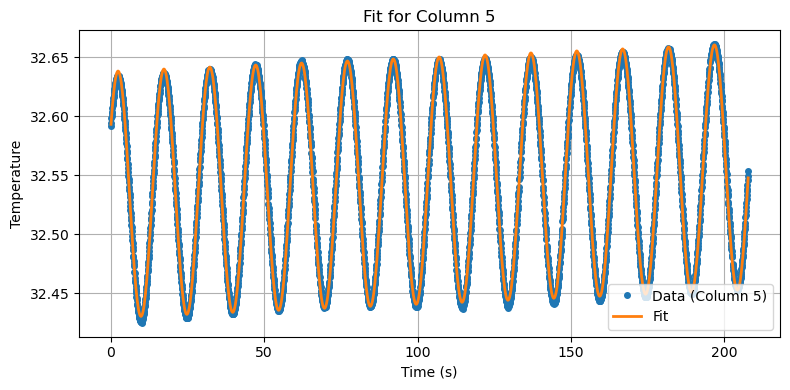


Column 6 fit results:
  A     = 0.0821 ± 0.0001
  omega = 0.419809 ± 0.000012 rad/s
  phi   = 0.0811 ± 0.0014 rad
  B     = 0.000114 ± 0.000001 (slope)
  C     = 32.5886 ± 0.0001 (offset)
  Period = 14.9668 ± 0.0004 s


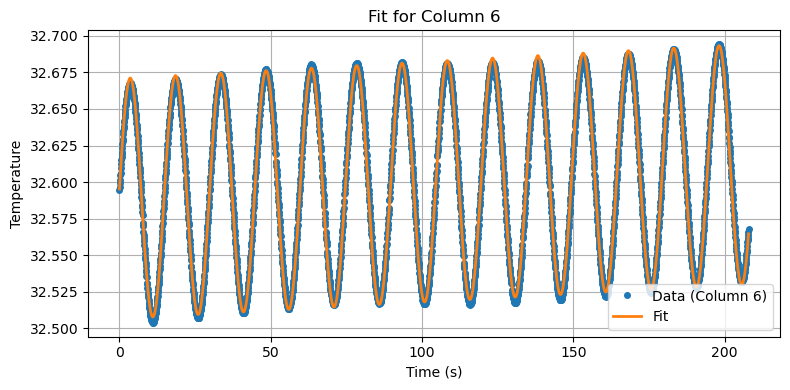


Column 7 fit results:
  A     = 0.0785 ± 0.0001
  omega = 0.419805 ± 0.000012 rad/s
  phi   = -0.2403 ± 0.0014 rad
  B     = 0.000113 ± 0.000001 (slope)
  C     = 32.5070 ± 0.0001 (offset)
  Period = 14.9669 ± 0.0004 s


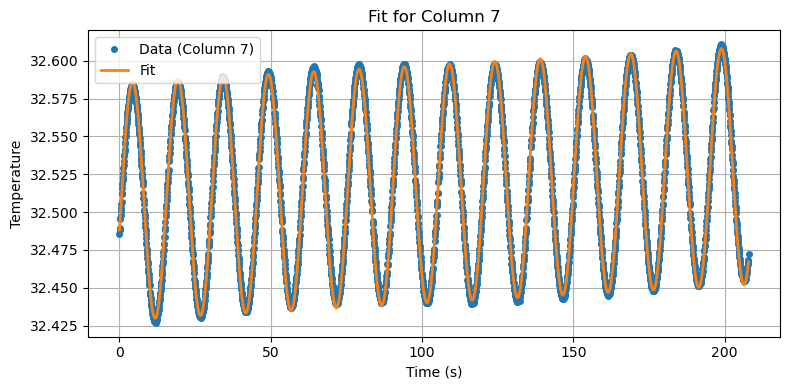


Column 0 fit results:
  A     = 0.8176 ± 0.0007
  omega = 0.419842 ± 0.000015 rad/s
  phi   = 2.7358 ± 0.0018 rad
  B     = 0.000117 ± 0.000009 (slope)
  C     = 32.6007 ± 0.0010 (offset)
  Period = 14.9656 ± 0.0005 s

Column 1 fit results:
  A     = 0.5649 ± 0.0004
  omega = 0.419836 ± 0.000013 rad/s
  phi   = 2.3653 ± 0.0015 rad
  B     = 0.000119 ± 0.000005 (slope)
  C     = 32.5659 ± 0.0006 (offset)
  Period = 14.9658 ± 0.0005 s

Column 2 fit results:
  A     = 0.3626 ± 0.0002
  omega = 0.419834 ± 0.000011 rad/s
  phi   = 1.9035 ± 0.0013 rad
  B     = 0.000118 ± 0.000003 (slope)
  C     = 32.5485 ± 0.0003 (offset)
  Period = 14.9659 ± 0.0004 s

Column 3 fit results:
  A     = 0.2425 ± 0.0001
  omega = 0.419834 ± 0.000010 rad/s
  phi   = 1.5622 ± 0.0012 rad
  B     = 0.000117 ± 0.000002 (slope)
  C     = 32.5092 ± 0.0002 (offset)
  Period = 14.9659 ± 0.0004 s

Column 4 fit results:
  A     = 0.1574 ± 0.0001
  omega = 0.419834 ± 0.000010 rad/s
  phi   = 1.1257 ± 0.0012 rad
  B     =

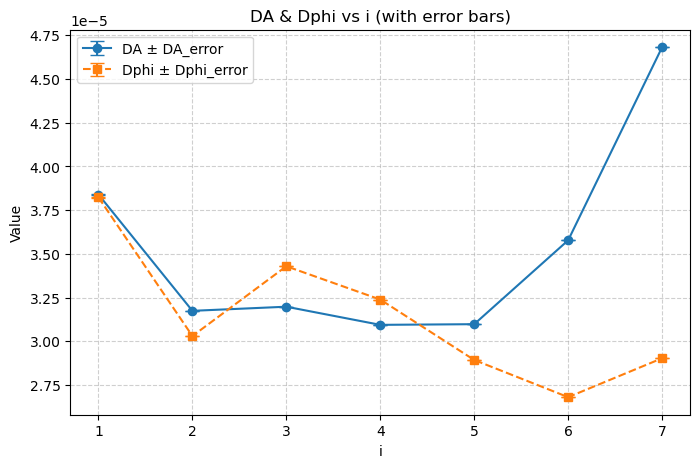

In [83]:
omega_guesses = [2 * np.pi / 15] * 8

def load_dataset(path):
	
	data = pd.read_csv(path, header=3)
	timestamp = data.iloc[:, 0].to_numpy()
	output_voltage = data.iloc[:, 1].to_numpy()
	output_current = data.iloc[:, 2].to_numpy()
	thermistor_temperatures = data.iloc[:, 3:].to_numpy()

	comments = re.search(r"Comments: (.*)$", open(path).read(), re.MULTILINE)[1]

	return timestamp, output_voltage, output_current, thermistor_temperatures, comments

timestamp, output_voltage, output_current, thermistor_temperatures, comments = (
	load_dataset("../data/brass data/brass 15s.csv")
)

plot_fit()

plot_D()



Column 0 fit results:
  A     = 0.5214 ± 0.0006
  omega = 0.629552 ± 0.000037 rad/s
  phi   = -3.0036 ± 0.0023 rad
  B     = -0.000121 ± 0.000014 (slope)
  C     = 32.7533 ± 0.0008 (offset)
  Period = 9.9804 ± 0.0006 s


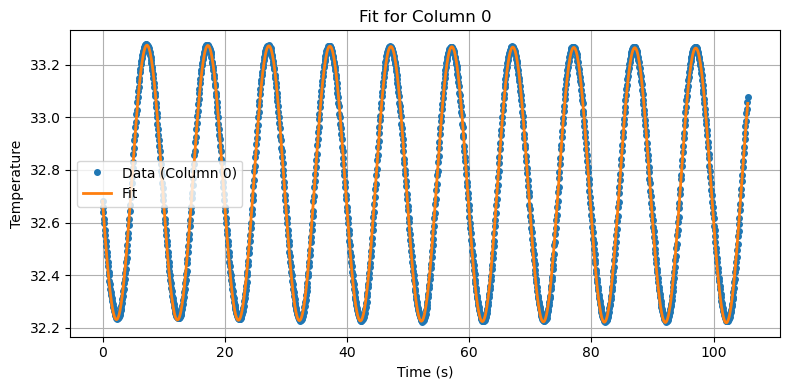


Column 1 fit results:
  A     = 0.3309 ± 0.0003
  omega = 0.629528 ± 0.000031 rad/s
  phi   = 2.8206 ± 0.0019 rad
  B     = -0.000128 ± 0.000007 (slope)
  C     = 32.7210 ± 0.0004 (offset)
  Period = 9.9808 ± 0.0005 s


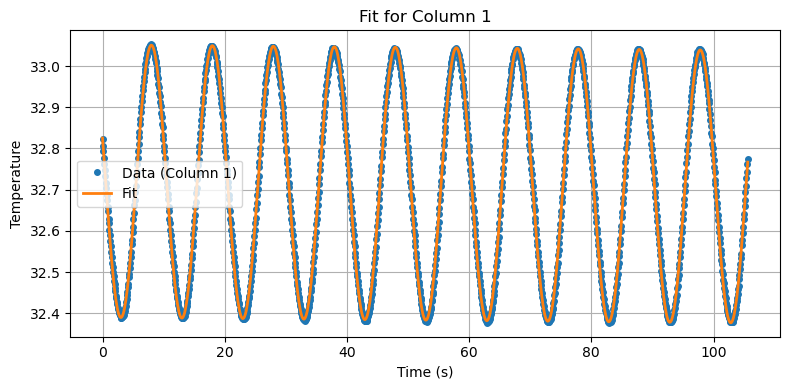


Column 2 fit results:
  A     = 0.1919 ± 0.0002
  omega = 0.629506 ± 0.000028 rad/s
  phi   = 2.2464 ± 0.0017 rad
  B     = -0.000129 ± 0.000004 (slope)
  C     = 32.7045 ± 0.0002 (offset)
  Period = 9.9811 ± 0.0004 s


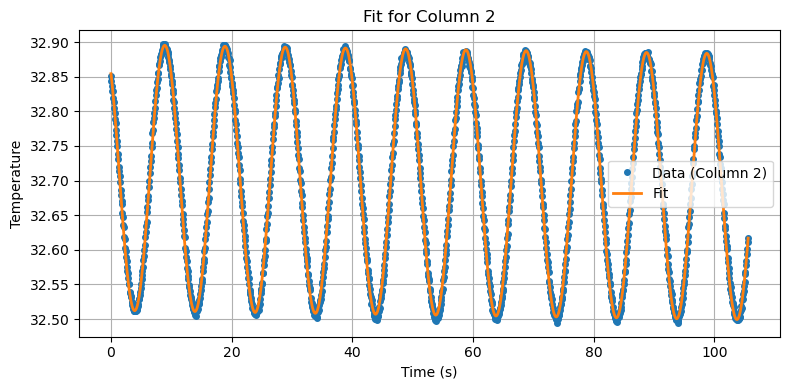


Column 3 fit results:
  A     = 0.1208 ± 0.0001
  omega = 0.629516 ± 0.000026 rad/s
  phi   = 1.8388 ± 0.0015 rad
  B     = -0.000133 ± 0.000002 (slope)
  C     = 32.6663 ± 0.0001 (offset)
  Period = 9.9810 ± 0.0004 s


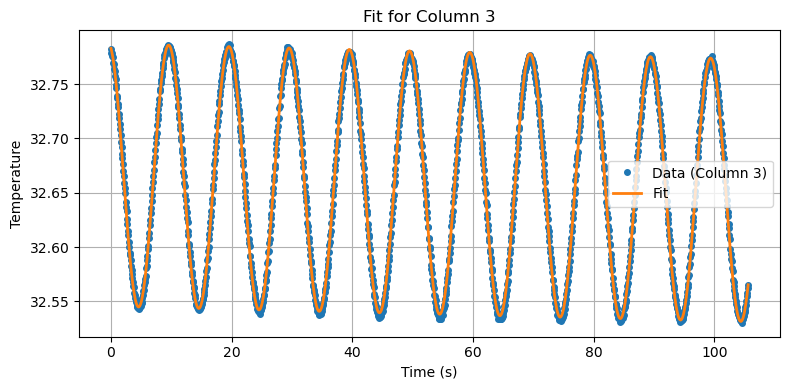


Column 4 fit results:
  A     = 0.0719 ± 0.0001
  omega = 0.629475 ± 0.000024 rad/s
  phi   = 1.3383 ± 0.0015 rad
  B     = -0.000135 ± 0.000001 (slope)
  C     = 32.7208 ± 0.0001 (offset)
  Period = 9.9816 ± 0.0004 s


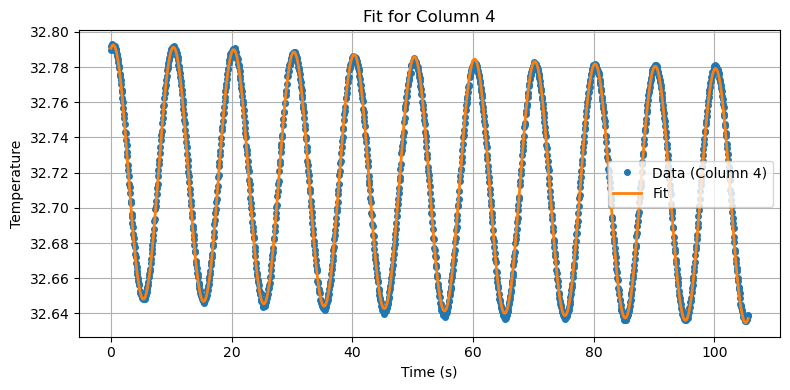


Column 5 fit results:
  A     = 0.0418 ± 0.0001
  omega = 0.629465 ± 0.000047 rad/s
  phi   = 0.7656 ± 0.0029 rad
  B     = -0.000139 ± 0.000001 (slope)
  C     = 32.6918 ± 0.0001 (offset)
  Period = 9.9818 ± 0.0007 s


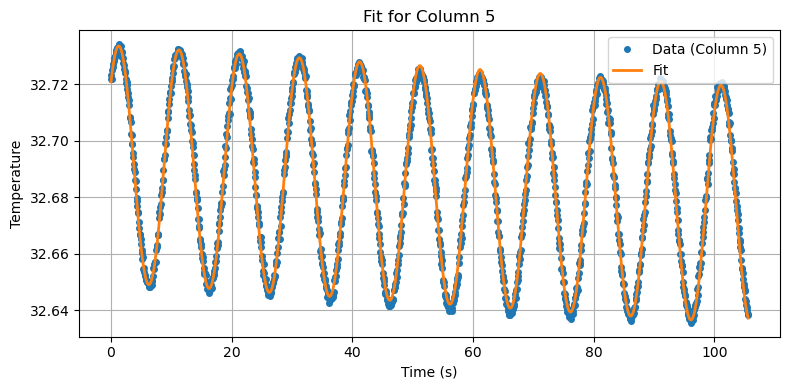


Column 6 fit results:
  A     = 0.0280 ± 0.0001
  omega = 0.629428 ± 0.000060 rad/s
  phi   = 0.1198 ± 0.0037 rad
  B     = -0.000141 ± 0.000001 (slope)
  C     = 32.7473 ± 0.0001 (offset)
  Period = 9.9824 ± 0.0010 s


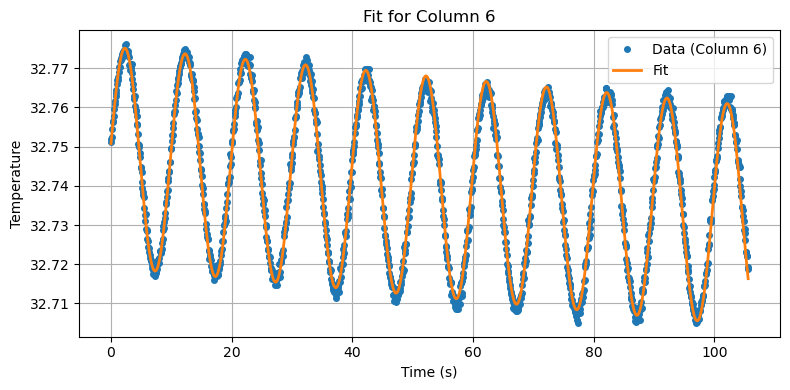


Column 7 fit results:
  A     = 0.0256 ± 0.0001
  omega = 0.629418 ± 0.000097 rad/s
  phi   = -0.3441 ± 0.0059 rad
  B     = -0.000143 ± 0.000002 (slope)
  C     = 32.6654 ± 0.0001 (offset)
  Period = 9.9825 ± 0.0015 s


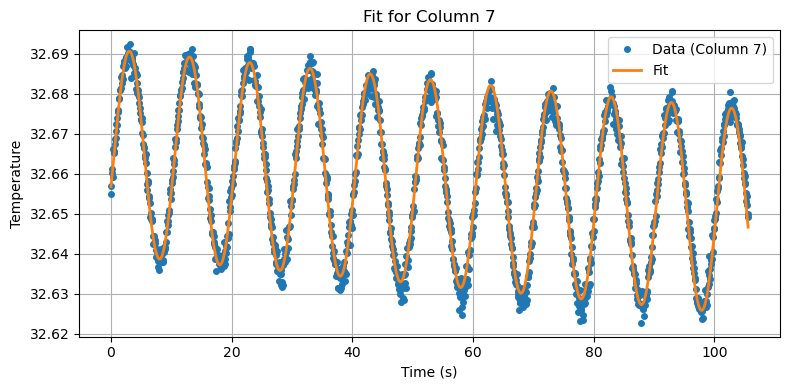


Column 0 fit results:
  A     = 0.5214 ± 0.0006
  omega = 0.629552 ± 0.000037 rad/s
  phi   = -3.0036 ± 0.0023 rad
  B     = -0.000121 ± 0.000014 (slope)
  C     = 32.7533 ± 0.0008 (offset)
  Period = 9.9804 ± 0.0006 s

Column 1 fit results:
  A     = 0.3309 ± 0.0003
  omega = 0.629528 ± 0.000031 rad/s
  phi   = 2.8206 ± 0.0019 rad
  B     = -0.000128 ± 0.000007 (slope)
  C     = 32.7210 ± 0.0004 (offset)
  Period = 9.9808 ± 0.0005 s

Column 2 fit results:
  A     = 0.1919 ± 0.0002
  omega = 0.629506 ± 0.000028 rad/s
  phi   = 2.2464 ± 0.0017 rad
  B     = -0.000129 ± 0.000004 (slope)
  C     = 32.7045 ± 0.0002 (offset)
  Period = 9.9811 ± 0.0004 s

Column 3 fit results:
  A     = 0.1208 ± 0.0001
  omega = 0.629516 ± 0.000026 rad/s
  phi   = 1.8388 ± 0.0015 rad
  B     = -0.000133 ± 0.000002 (slope)
  C     = 32.6663 ± 0.0001 (offset)
  Period = 9.9810 ± 0.0004 s

Column 4 fit results:
  A     = 0.0719 ± 0.0001
  omega = 0.629475 ± 0.000024 rad/s
  phi   = 1.3383 ± 0.0015 rad
  B     

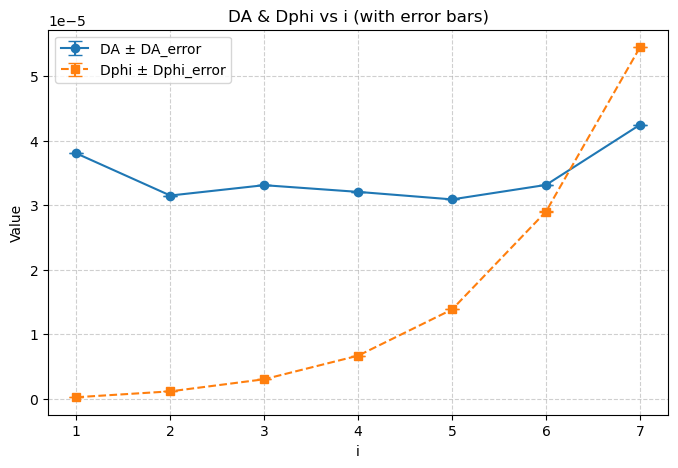

In [84]:
omega_guesses = [2 * np.pi / 10] * 8

def load_dataset(path):
	
	data = pd.read_csv(path, header=3)
	timestamp = data.iloc[:, 0].to_numpy()
	output_voltage = data.iloc[:, 1].to_numpy()
	output_current = data.iloc[:, 2].to_numpy()
	thermistor_temperatures = data.iloc[:, 3:].to_numpy()

	comments = re.search(r"Comments: (.*)$", open(path).read(), re.MULTILINE)[1]

	return timestamp, output_voltage, output_current, thermistor_temperatures, comments

timestamp, output_voltage, output_current, thermistor_temperatures, comments = (
	load_dataset("../data/brass data/brass 10s.csv")
)

plot_fit()

plot_D()



Column 0 fit results:
  A     = 0.2190 ± 0.0003
  omega = 1.258864 ± 0.000074 rad/s
  phi   = -0.8221 ± 0.0023 rad
  B     = 0.000646 ± 0.000012 (slope)
  C     = 32.5775 ± 0.0004 (offset)
  Period = 4.9912 ± 0.0003 s


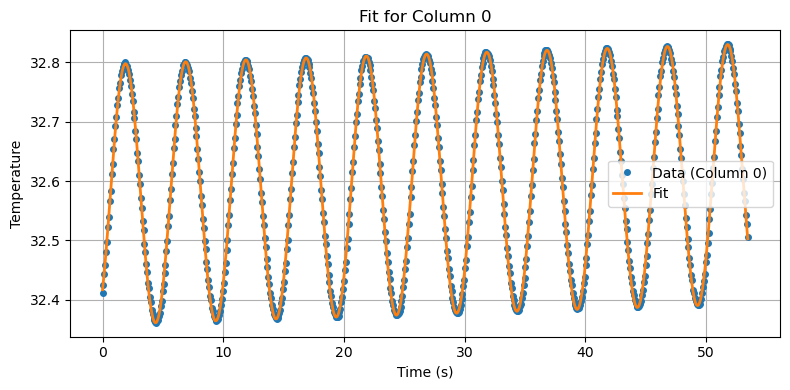


Column 1 fit results:
  A     = 0.1136 ± 0.0001
  omega = 1.258853 ± 0.000060 rad/s
  phi   = -1.4709 ± 0.0019 rad
  B     = 0.000631 ± 0.000005 (slope)
  C     = 32.5413 ± 0.0001 (offset)
  Period = 4.9912 ± 0.0002 s


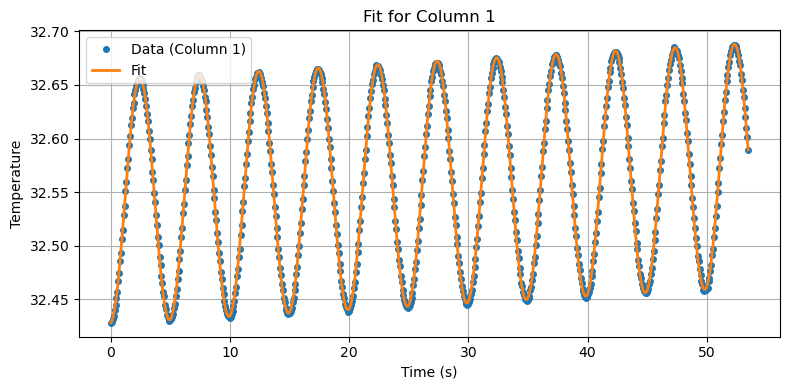


Column 2 fit results:
  A     = 0.0515 ± 0.0000
  omega = 1.258843 ± 0.000064 rad/s
  phi   = -2.2866 ± 0.0020 rad
  B     = 0.000613 ± 0.000002 (slope)
  C     = 32.5213 ± 0.0001 (offset)
  Period = 4.9912 ± 0.0003 s


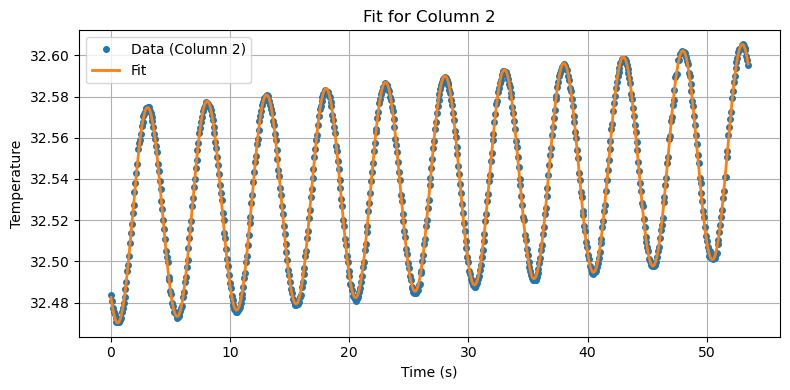


Column 3 fit results:
  A     = 0.0277 ± 0.0000
  omega = 1.258821 ± 0.000077 rad/s
  phi   = -2.8701 ± 0.0024 rad
  B     = 0.000606 ± 0.000002 (slope)
  C     = 32.4806 ± 0.0000 (offset)
  Period = 4.9913 ± 0.0003 s


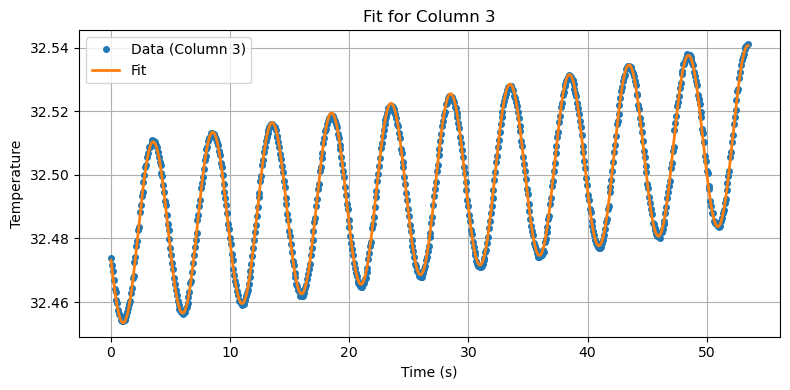


Column 4 fit results:
  A     = 0.0136 ± 0.0000
  omega = 1.259246 ± 0.000181 rad/s
  phi   = 2.7030 ± 0.0056 rad
  B     = 0.000592 ± 0.000002 (slope)
  C     = 32.5329 ± 0.0001 (offset)
  Period = 4.9896 ± 0.0007 s


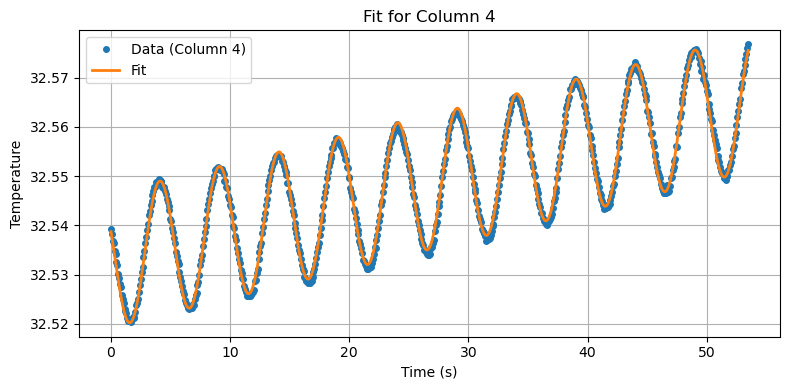


Column 5 fit results:
  A     = 0.0064 ± 0.0000
  omega = 1.259654 ± 0.000300 rad/s
  phi   = 1.9641 ± 0.0093 rad
  B     = 0.000584 ± 0.000001 (slope)
  C     = 32.5023 ± 0.0000 (offset)
  Period = 4.9880 ± 0.0012 s


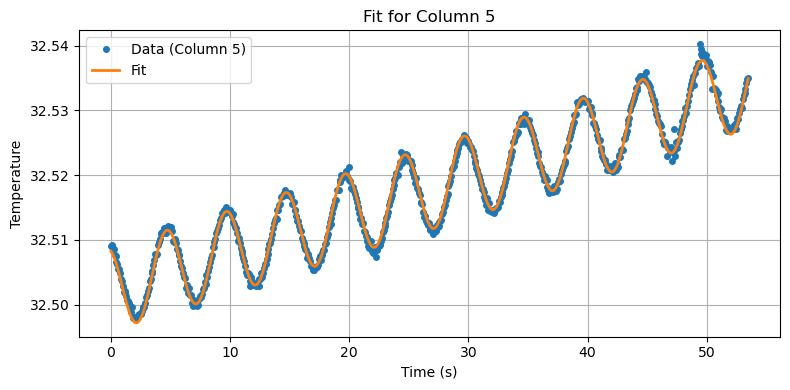


Column 6 fit results:
  A     = 0.0031 ± 0.0000
  omega = 1.258684 ± 0.000598 rad/s
  phi   = 1.1760 ± 0.0184 rad
  B     = 0.000580 ± 0.000001 (slope)
  C     = 32.5565 ± 0.0000 (offset)
  Period = 4.9919 ± 0.0024 s


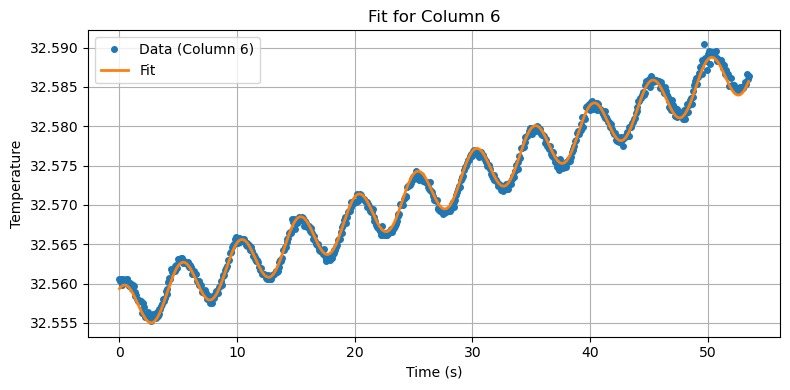


Column 7 fit results:
  A     = 0.0022 ± 0.0001
  omega = 1.256459 ± 0.001641 rad/s
  phi   = 0.5900 ± 0.0506 rad
  B     = 0.000574 ± 0.000003 (slope)
  C     = 32.4741 ± 0.0001 (offset)
  Period = 5.0007 ± 0.0065 s


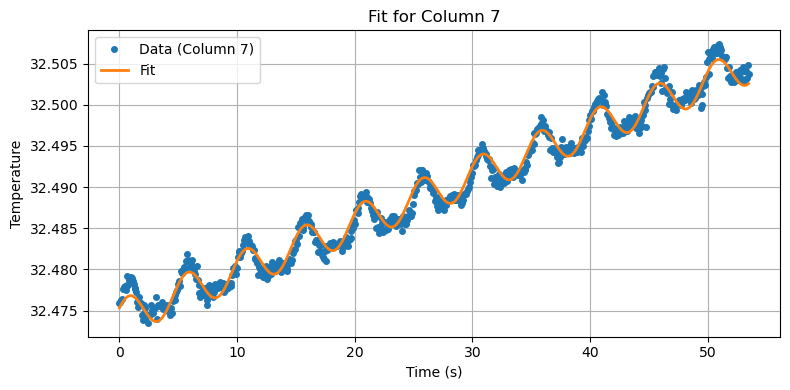


Column 0 fit results:
  A     = 0.2190 ± 0.0003
  omega = 1.258864 ± 0.000074 rad/s
  phi   = -0.8221 ± 0.0023 rad
  B     = 0.000646 ± 0.000012 (slope)
  C     = 32.5775 ± 0.0004 (offset)
  Period = 4.9912 ± 0.0003 s

Column 1 fit results:
  A     = 0.1136 ± 0.0001
  omega = 1.258853 ± 0.000060 rad/s
  phi   = -1.4709 ± 0.0019 rad
  B     = 0.000631 ± 0.000005 (slope)
  C     = 32.5413 ± 0.0001 (offset)
  Period = 4.9912 ± 0.0002 s

Column 2 fit results:
  A     = 0.0515 ± 0.0000
  omega = 1.258843 ± 0.000064 rad/s
  phi   = -2.2866 ± 0.0020 rad
  B     = 0.000613 ± 0.000002 (slope)
  C     = 32.5213 ± 0.0001 (offset)
  Period = 4.9912 ± 0.0003 s

Column 3 fit results:
  A     = 0.0277 ± 0.0000
  omega = 1.258821 ± 0.000077 rad/s
  phi   = -2.8701 ± 0.0024 rad
  B     = 0.000606 ± 0.000002 (slope)
  C     = 32.4806 ± 0.0000 (offset)
  Period = 4.9913 ± 0.0003 s

Column 4 fit results:
  A     = 0.0136 ± 0.0000
  omega = 1.259246 ± 0.000181 rad/s
  phi   = 2.7030 ± 0.0056 rad
  B     =

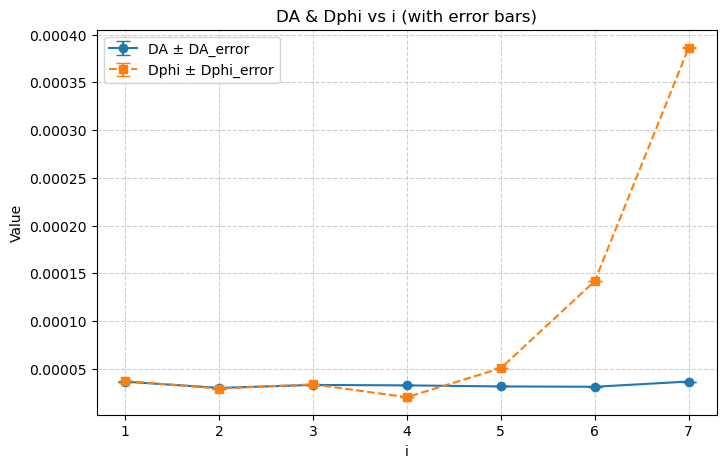

In [85]:
omega_guesses = [2 * np.pi / 5] * 8

def load_dataset(path):
	
	data = pd.read_csv(path, header=3)
	timestamp = data.iloc[:, 0].to_numpy()
	output_voltage = data.iloc[:, 1].to_numpy()
	output_current = data.iloc[:, 2].to_numpy()
	thermistor_temperatures = data.iloc[:, 3:].to_numpy()

	comments = re.search(r"Comments: (.*)$", open(path).read(), re.MULTILINE)[1]

	return timestamp, output_voltage, output_current, thermistor_temperatures, comments

timestamp, output_voltage, output_current, thermistor_temperatures, comments = (
	load_dataset("../data/brass data/brass 5s.csv")
)

plot_fit()

plot_D()



Column 0 fit results:
  A     = 0.0680 ± 0.0001
  omega = 2.519665 ± 0.000050 rad/s
  phi   = 2.3224 ± 0.0050 rad
  B     = -0.000168 ± 0.000002 (slope)
  C     = 32.2586 ± 0.0002 (offset)
  Period = 2.4937 ± 0.0000 s


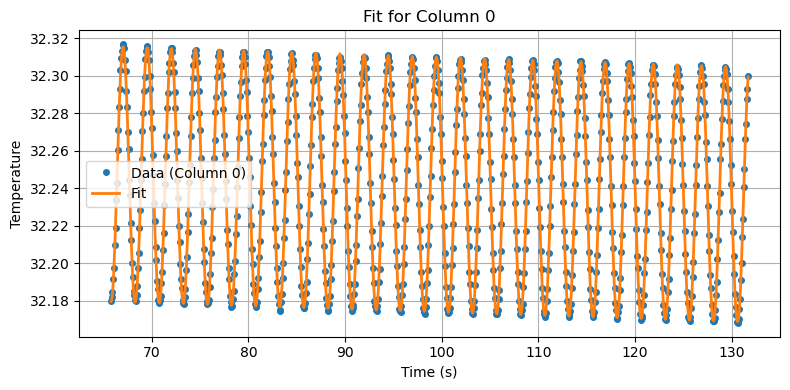


Column 1 fit results:
  A     = 0.0262 ± 0.0000
  omega = 2.519689 ± 0.000065 rad/s
  phi   = 1.4235 ± 0.0066 rad
  B     = -0.000173 ± 0.000001 (slope)
  C     = 32.2241 ± 0.0001 (offset)
  Period = 2.4936 ± 0.0001 s


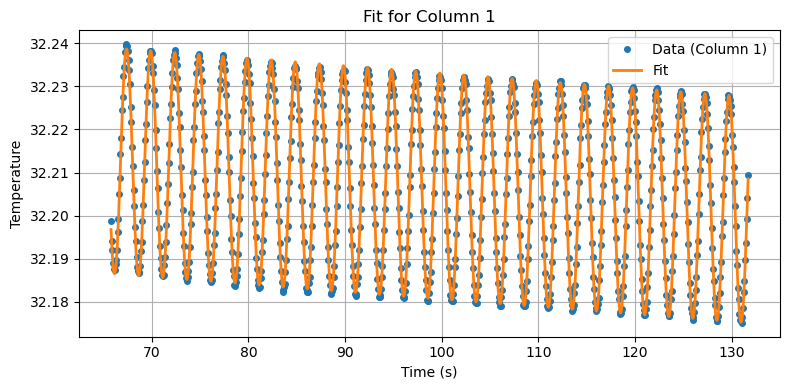


Column 2 fit results:
  A     = 0.0085 ± 0.0000
  omega = 2.519697 ± 0.000190 rad/s
  phi   = 0.2885 ± 0.0191 rad
  B     = -0.000178 ± 0.000001 (slope)
  C     = 32.2093 ± 0.0001 (offset)
  Period = 2.4936 ± 0.0002 s


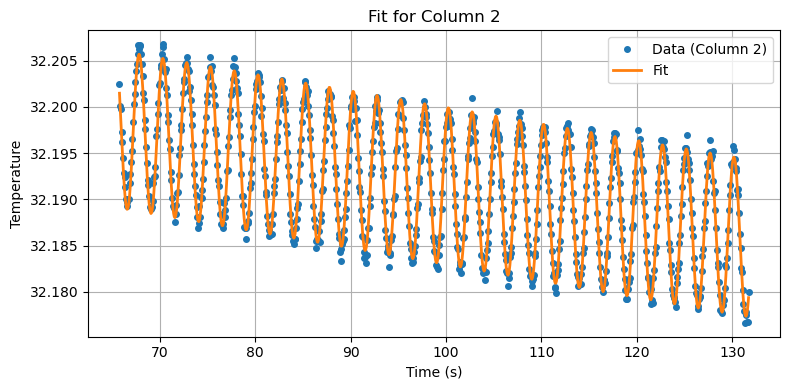


Column 3 fit results:
  A     = 0.0036 ± 0.0000
  omega = 2.519804 ± 0.000343 rad/s
  phi   = -0.5605 ± 0.0345 rad
  B     = -0.000183 ± 0.000001 (slope)
  C     = 32.1712 ± 0.0001 (offset)
  Period = 2.4935 ± 0.0003 s


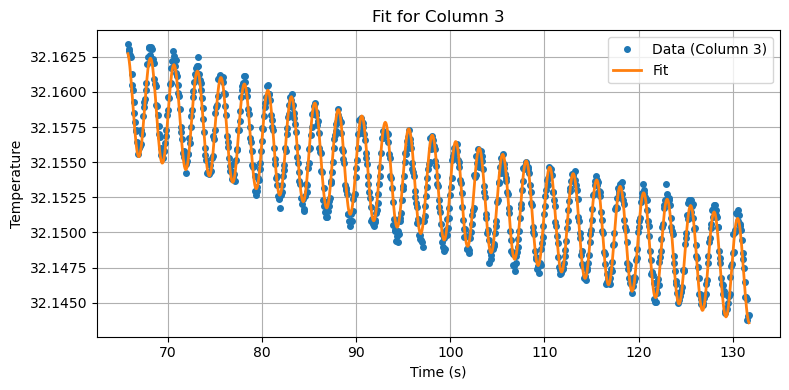


Column 4 fit results:
  A     = 0.0013 ± 0.0000
  omega = 2.519888 ± 0.001287 rad/s
  phi   = -1.3627 ± 0.1297 rad
  B     = -0.000185 ± 0.000001 (slope)
  C     = 32.2272 ± 0.0001 (offset)
  Period = 2.4934 ± 0.0013 s


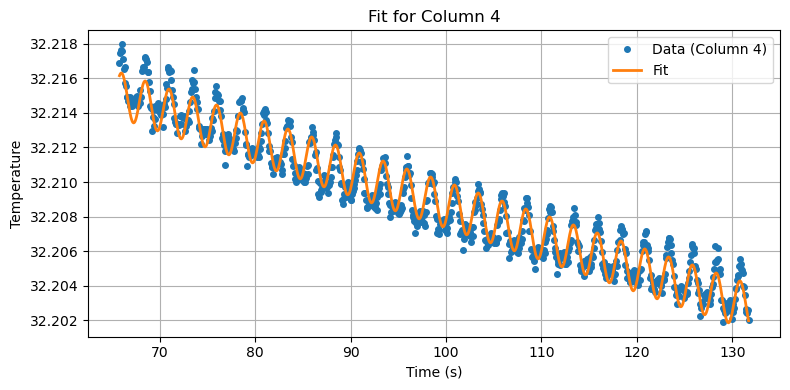


Column 5 fit results:
  A     = 0.0005 ± 0.0000
  omega = 2.517122 ± 0.002721 rad/s
  phi   = -2.2137 ± 0.2733 rad
  B     = -0.000188 ± 0.000001 (slope)
  C     = 32.1975 ± 0.0001 (offset)
  Period = 2.4962 ± 0.0027 s


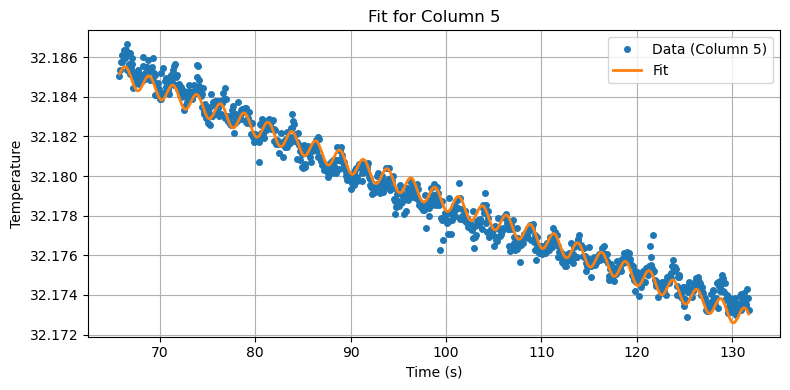


Column 6 fit results:
  A     = 0.0002 ± 0.0000
  omega = 2.522050 ± 0.005819 rad/s
  phi   = 2.6489 ± 0.5845 rad
  B     = -0.000189 ± 0.000001 (slope)
  C     = 32.2523 ± 0.0001 (offset)
  Period = 2.4913 ± 0.0057 s


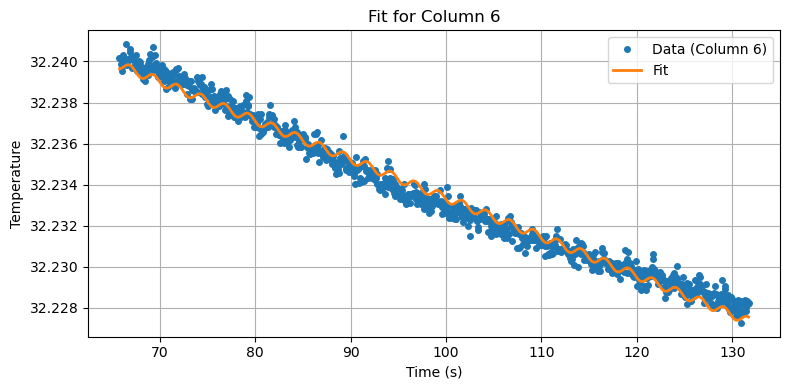


Column 7 fit results:
  A     = 0.0004 ± 0.0000
  omega = 2.518936 ± 0.006126 rad/s
  phi   = 0.3637 ± 0.6149 rad
  B     = -0.000190 ± 0.000002 (slope)
  C     = 32.1722 ± 0.0002 (offset)
  Period = 2.4944 ± 0.0061 s


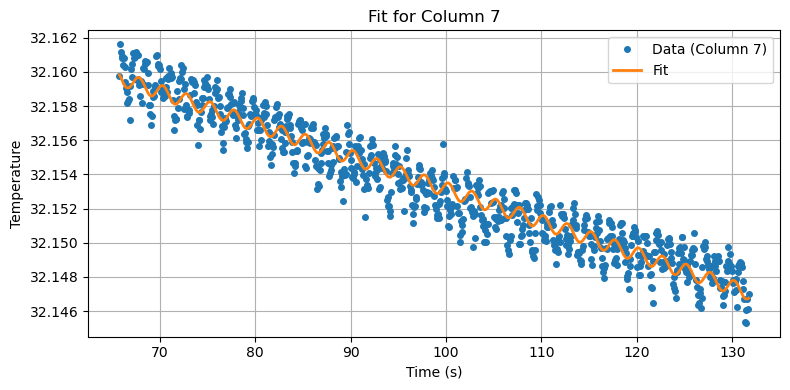


Column 0 fit results:
  A     = 0.0680 ± 0.0001
  omega = 2.519665 ± 0.000050 rad/s
  phi   = 2.3224 ± 0.0050 rad
  B     = -0.000168 ± 0.000002 (slope)
  C     = 32.2586 ± 0.0002 (offset)
  Period = 2.4937 ± 0.0000 s

Column 1 fit results:
  A     = 0.0262 ± 0.0000
  omega = 2.519689 ± 0.000065 rad/s
  phi   = 1.4235 ± 0.0066 rad
  B     = -0.000173 ± 0.000001 (slope)
  C     = 32.2241 ± 0.0001 (offset)
  Period = 2.4936 ± 0.0001 s

Column 2 fit results:
  A     = 0.0085 ± 0.0000
  omega = 2.519697 ± 0.000190 rad/s
  phi   = 0.2885 ± 0.0191 rad
  B     = -0.000178 ± 0.000001 (slope)
  C     = 32.2093 ± 0.0001 (offset)
  Period = 2.4936 ± 0.0002 s

Column 3 fit results:
  A     = 0.0036 ± 0.0000
  omega = 2.519804 ± 0.000343 rad/s
  phi   = -0.5605 ± 0.0345 rad
  B     = -0.000183 ± 0.000001 (slope)
  C     = 32.1712 ± 0.0001 (offset)
  Period = 2.4935 ± 0.0003 s

Column 4 fit results:
  A     = 0.0013 ± 0.0000
  omega = 2.519888 ± 0.001287 rad/s
  phi   = -1.3627 ± 0.1297 rad
  B    

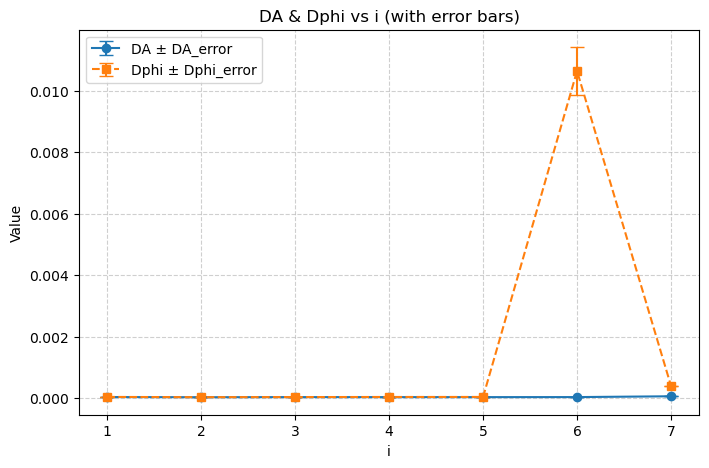

In [89]:
omega_guesses = [2 * np.pi / 2.5] * 8

def load_dataset(path):
	
	data = pd.read_csv(path, header=3)
	timestamp = data.iloc[:, 0].to_numpy()
	output_voltage = data.iloc[:, 1].to_numpy()
	output_current = data.iloc[:, 2].to_numpy()
	thermistor_temperatures = data.iloc[:, 3:].to_numpy()

	comments = re.search(r"Comments: (.*)$", open(path).read(), re.MULTILINE)[1]

	return timestamp, output_voltage, output_current, thermistor_temperatures, comments

timestamp, output_voltage, output_current, thermistor_temperatures, comments = (
	load_dataset("../data/brass data/brass 2.5s.csv")
)

plot_fit()

plot_D()
